In [1]:
import toml
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
import seaborn as sns

In [2]:
scan_path = Path('/n/groups/datta/win/longtogeny/size_norm/models/big_param_scan_00')

In [3]:
def get_mag(s):
    if s == 'K':
        return 1e3
    elif s == 'M':
        return 1e6
    elif s == 'B':
        return 1e9
    else:
        raise NotImplementedError()

## Stage 1

In [88]:
metrics = list(scan_path.glob("stage_01/**/metrics.csv"))

In [89]:
results = []
for f in tqdm(metrics):
    try:
        folder = f.parents[2]
        config = toml.load(folder / "config.toml")
        mse_df = pd.read_csv(f)
        tmp = mse_df.groupby('epoch').mean()
        with open(list(folder.glob('model*.out'))[0], 'r') as out_f:
            for line in out_f.readlines():
                if "Total params" in line:
                    params = line.split(' ')[:2]
                    params = float(params[0]) * get_mag(params[1])
        out = dict(
            depth=config['model']['depth'],
            arch=config['model']['lightning']['arch'],
            channel_scaling=config['model']['channel_scaling'],
            depth_scaling=config['model']['depth_scaling'],
            init_depth=config['model']['init_depth'],
            init_channel=config['model']['init_channel'],
            val_mse=None if 'val_loss' not in mse_df.columns else mse_df['val_loss'].min(),
            uuid=folder.name,
            train_mse=tmp['train_loss'].min(),
            epoch=mse_df['epoch'].max(),
            param_count=params,
            file=str(folder / "model.pt"),
            activation=config['model']['activation'],
        )
        if 'dynamics_correlation' in mse_df.columns:
            out['dynamics_corr'] = mse_df['dynamics_correlation'].dropna().iloc[-1]
        if 'age_classification' in mse_df.columns:
            out['age_class'] = mse_df['age_classification'].dropna().iloc[-1]
        results.append(out)
    except Exception:
        continue
results = pd.DataFrame(results)

  0%|          | 0/287 [00:00<?, ?it/s]

In [46]:
results[['param_count', 'epoch']]

param_count  epoch
0      5600000.0    100
1    123000000.0     12
2    123000000.0     25
3      4100000.0     75
4      4100000.0    100
..           ...    ...
254   31500000.0    100
255   82300000.0     43
256  775000000.0      0
257  264000000.0      0
258  264000000.0     21

[259 rows x 2 columns]

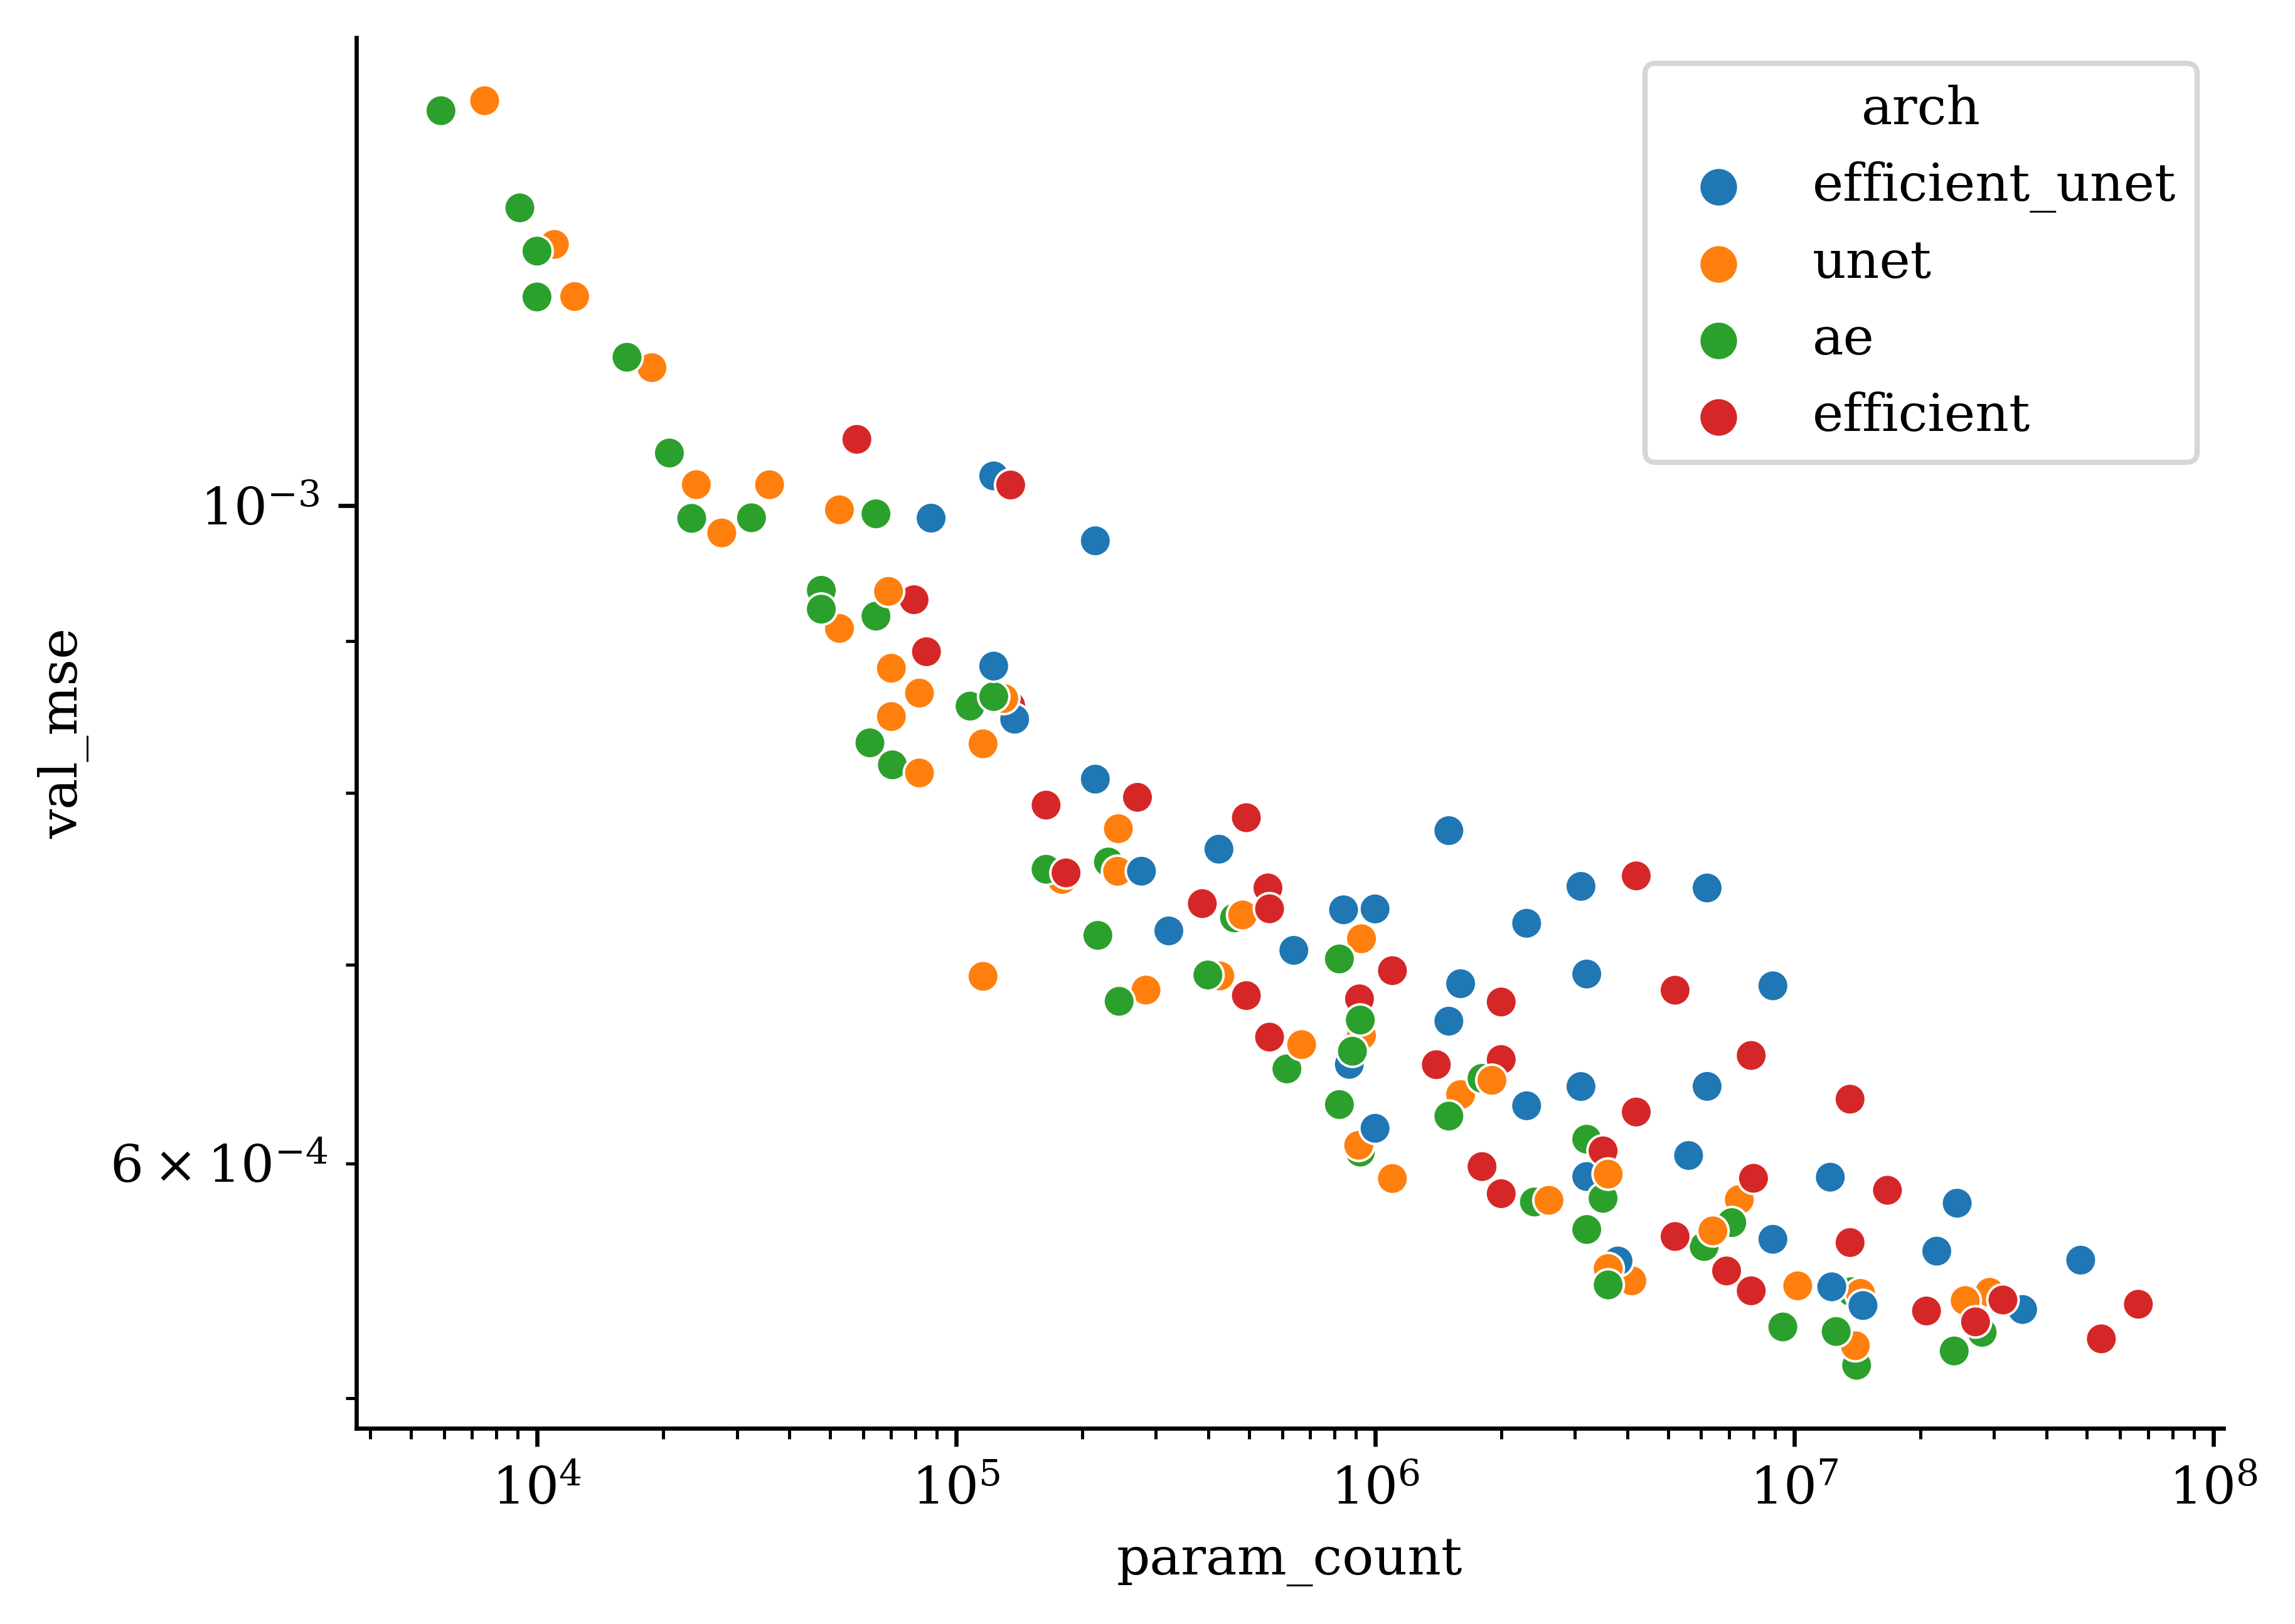

In [90]:
ax = sns.scatterplot(data=results.query('epoch == 100'), x='param_count', y='val_mse', hue='arch')
ax.set(xscale='log', yscale='log')
sns.despine()

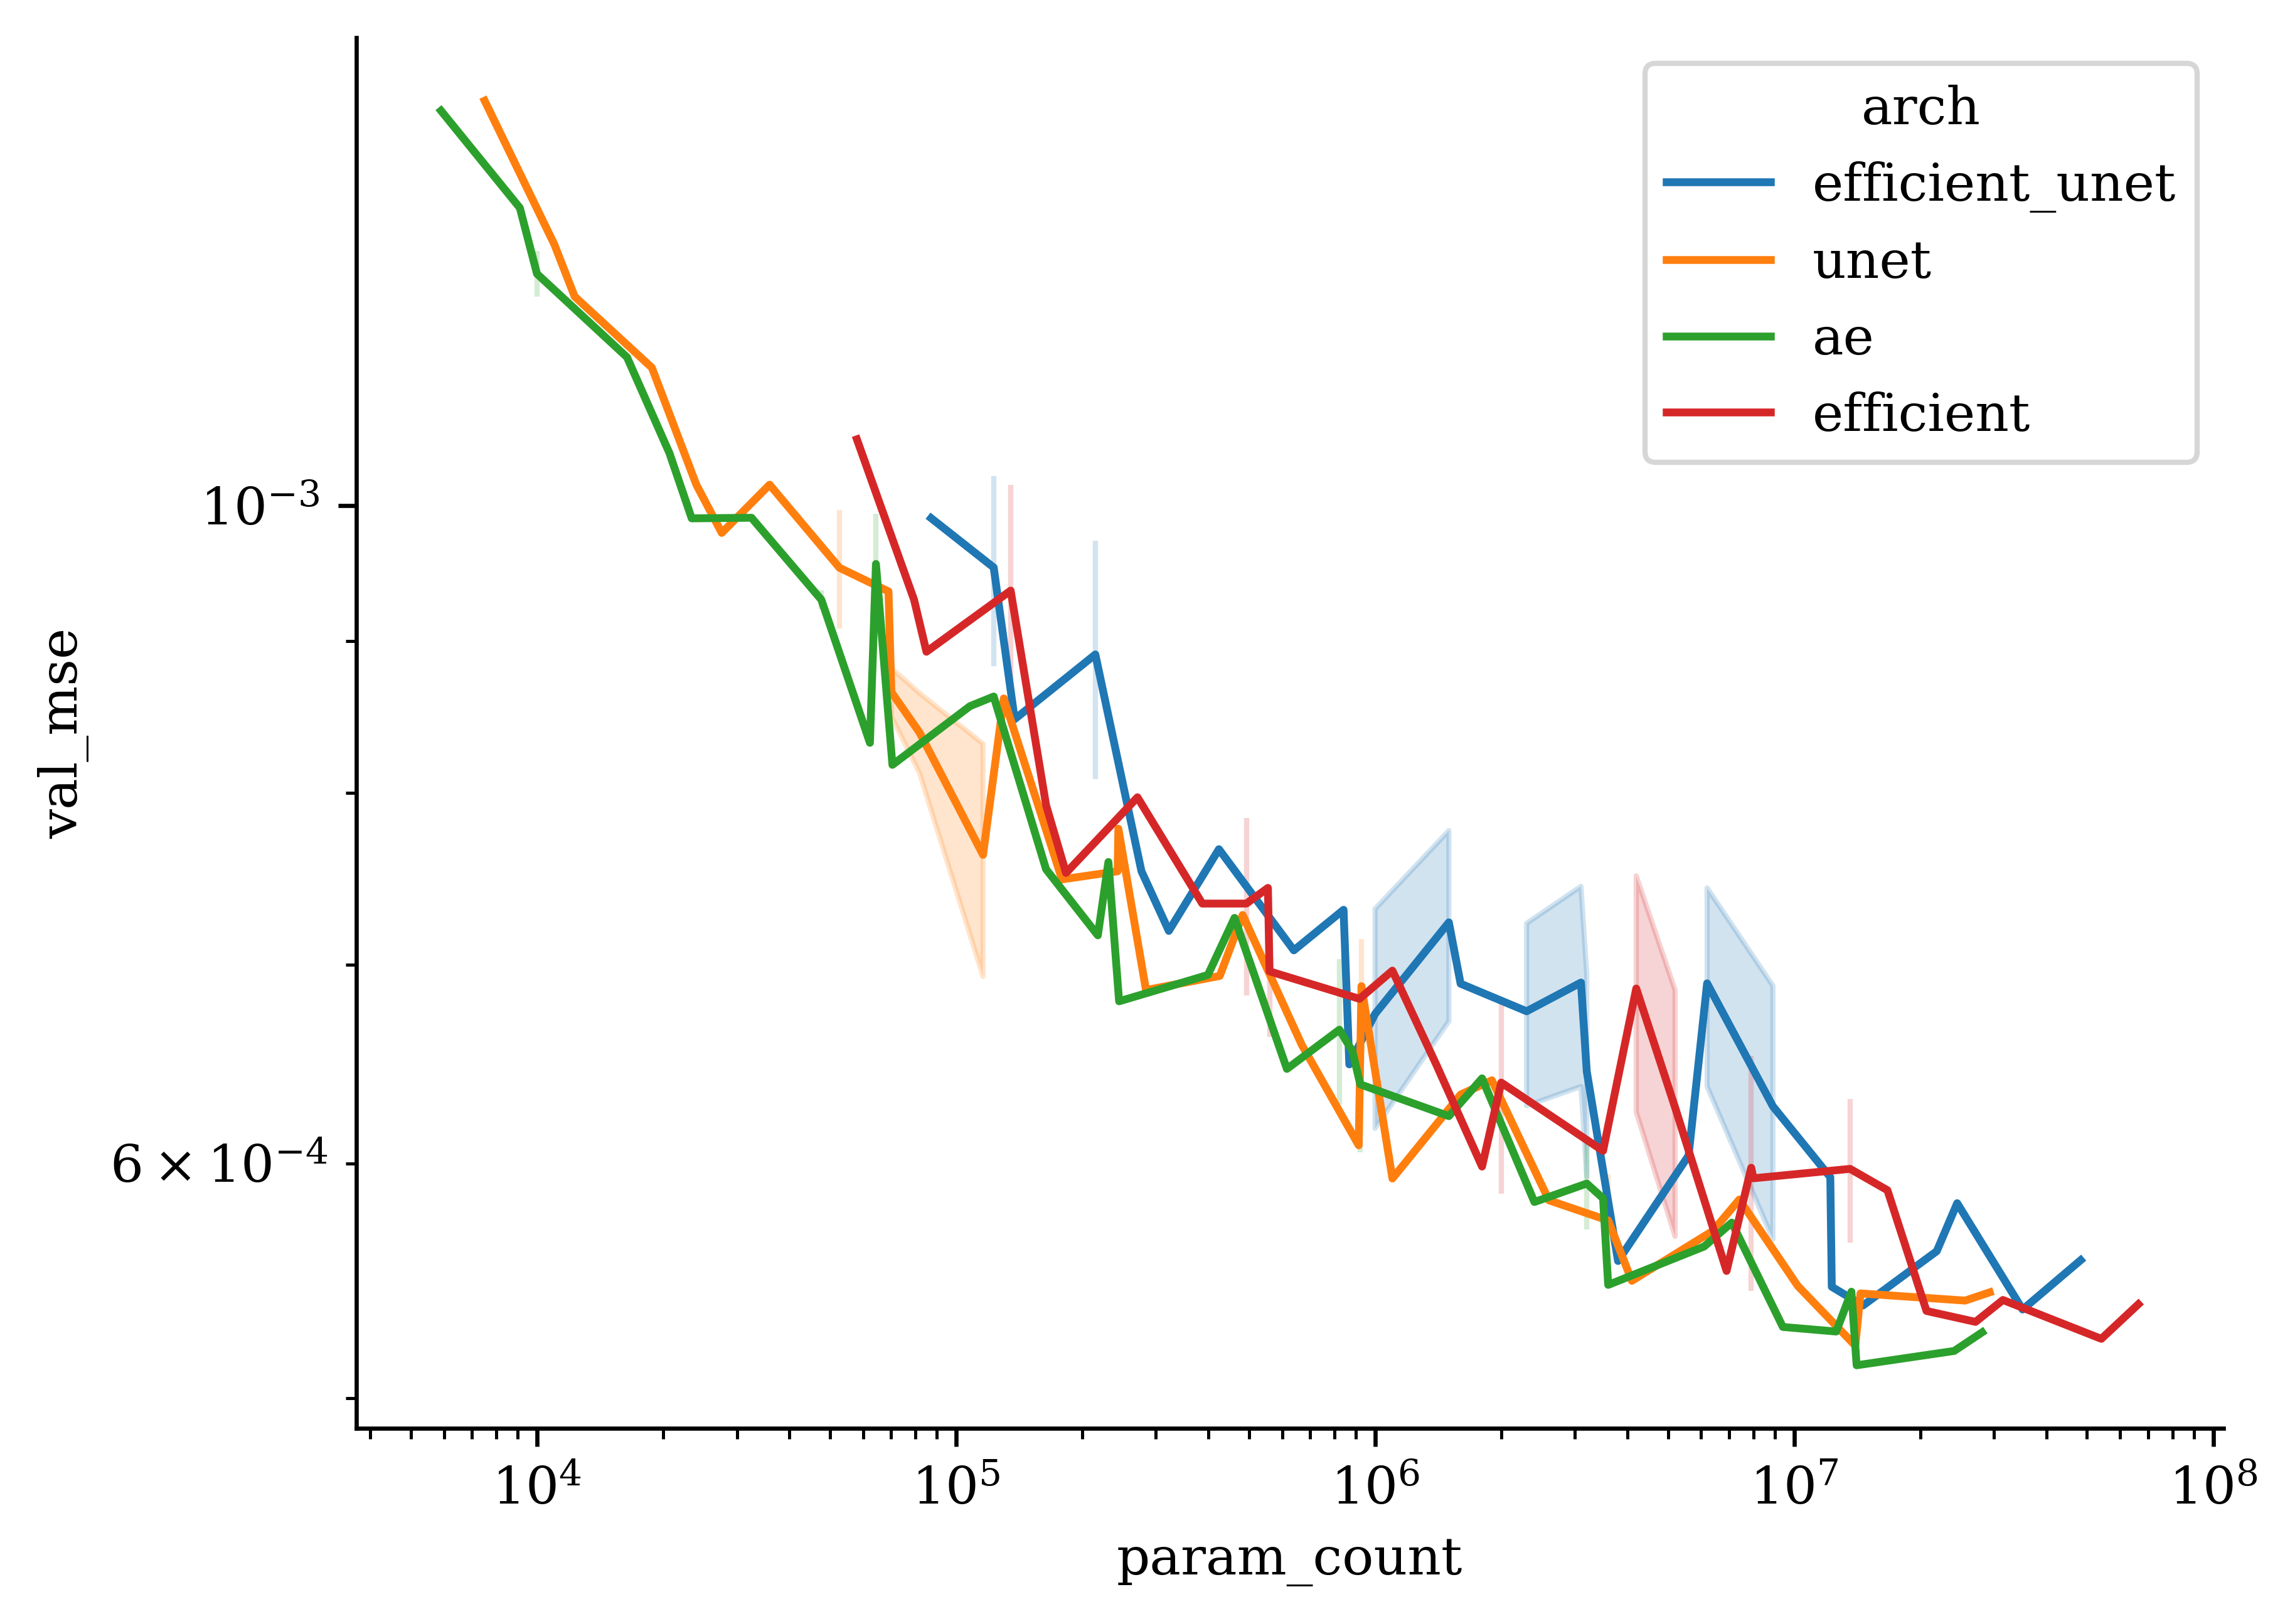

In [91]:
ax = sns.lineplot(data=results.query('epoch == 100'), x='param_count', y='val_mse', hue='arch')
ax.set(xscale='log', yscale='log')
sns.despine()

In [49]:
results.loc[results.query('epoch == 100')['val_mse'].idxmin()]

depth                                                              4
arch                                                              ae
channel_scaling                                                  1.5
depth_scaling                                                    1.0
init_depth                                                         1
init_channel                                                     512
val_mse                                                     0.000513
uuid                            13fd909a-a1e3-44d7-8daf-9c029ee5408b
train_mse                                                   0.000461
epoch                                                            100
param_count                                               14100000.0
file               /n/groups/datta/win/longtogeny/size_norm/model...
activation                                                      GELU
dynamics_corr                                               0.858104
age_class                         

In [50]:
results.loc[results.query('epoch == 100')['dynamics_corr'].idxmax()]

depth                                                              4
arch                                                  efficient_unet
channel_scaling                                                  2.5
depth_scaling                                                    1.0
init_depth                                                         1
init_channel                                                      16
val_mse                                                     0.000723
uuid                            e296c6e9-b125-4afd-8efa-65e53fba0c9c
train_mse                                                   0.000575
epoch                                                            100
param_count                                                2300000.0
file               /n/groups/datta/win/longtogeny/size_norm/model...
activation                                                      GELU
dynamics_corr                                                0.87058
age_class                         

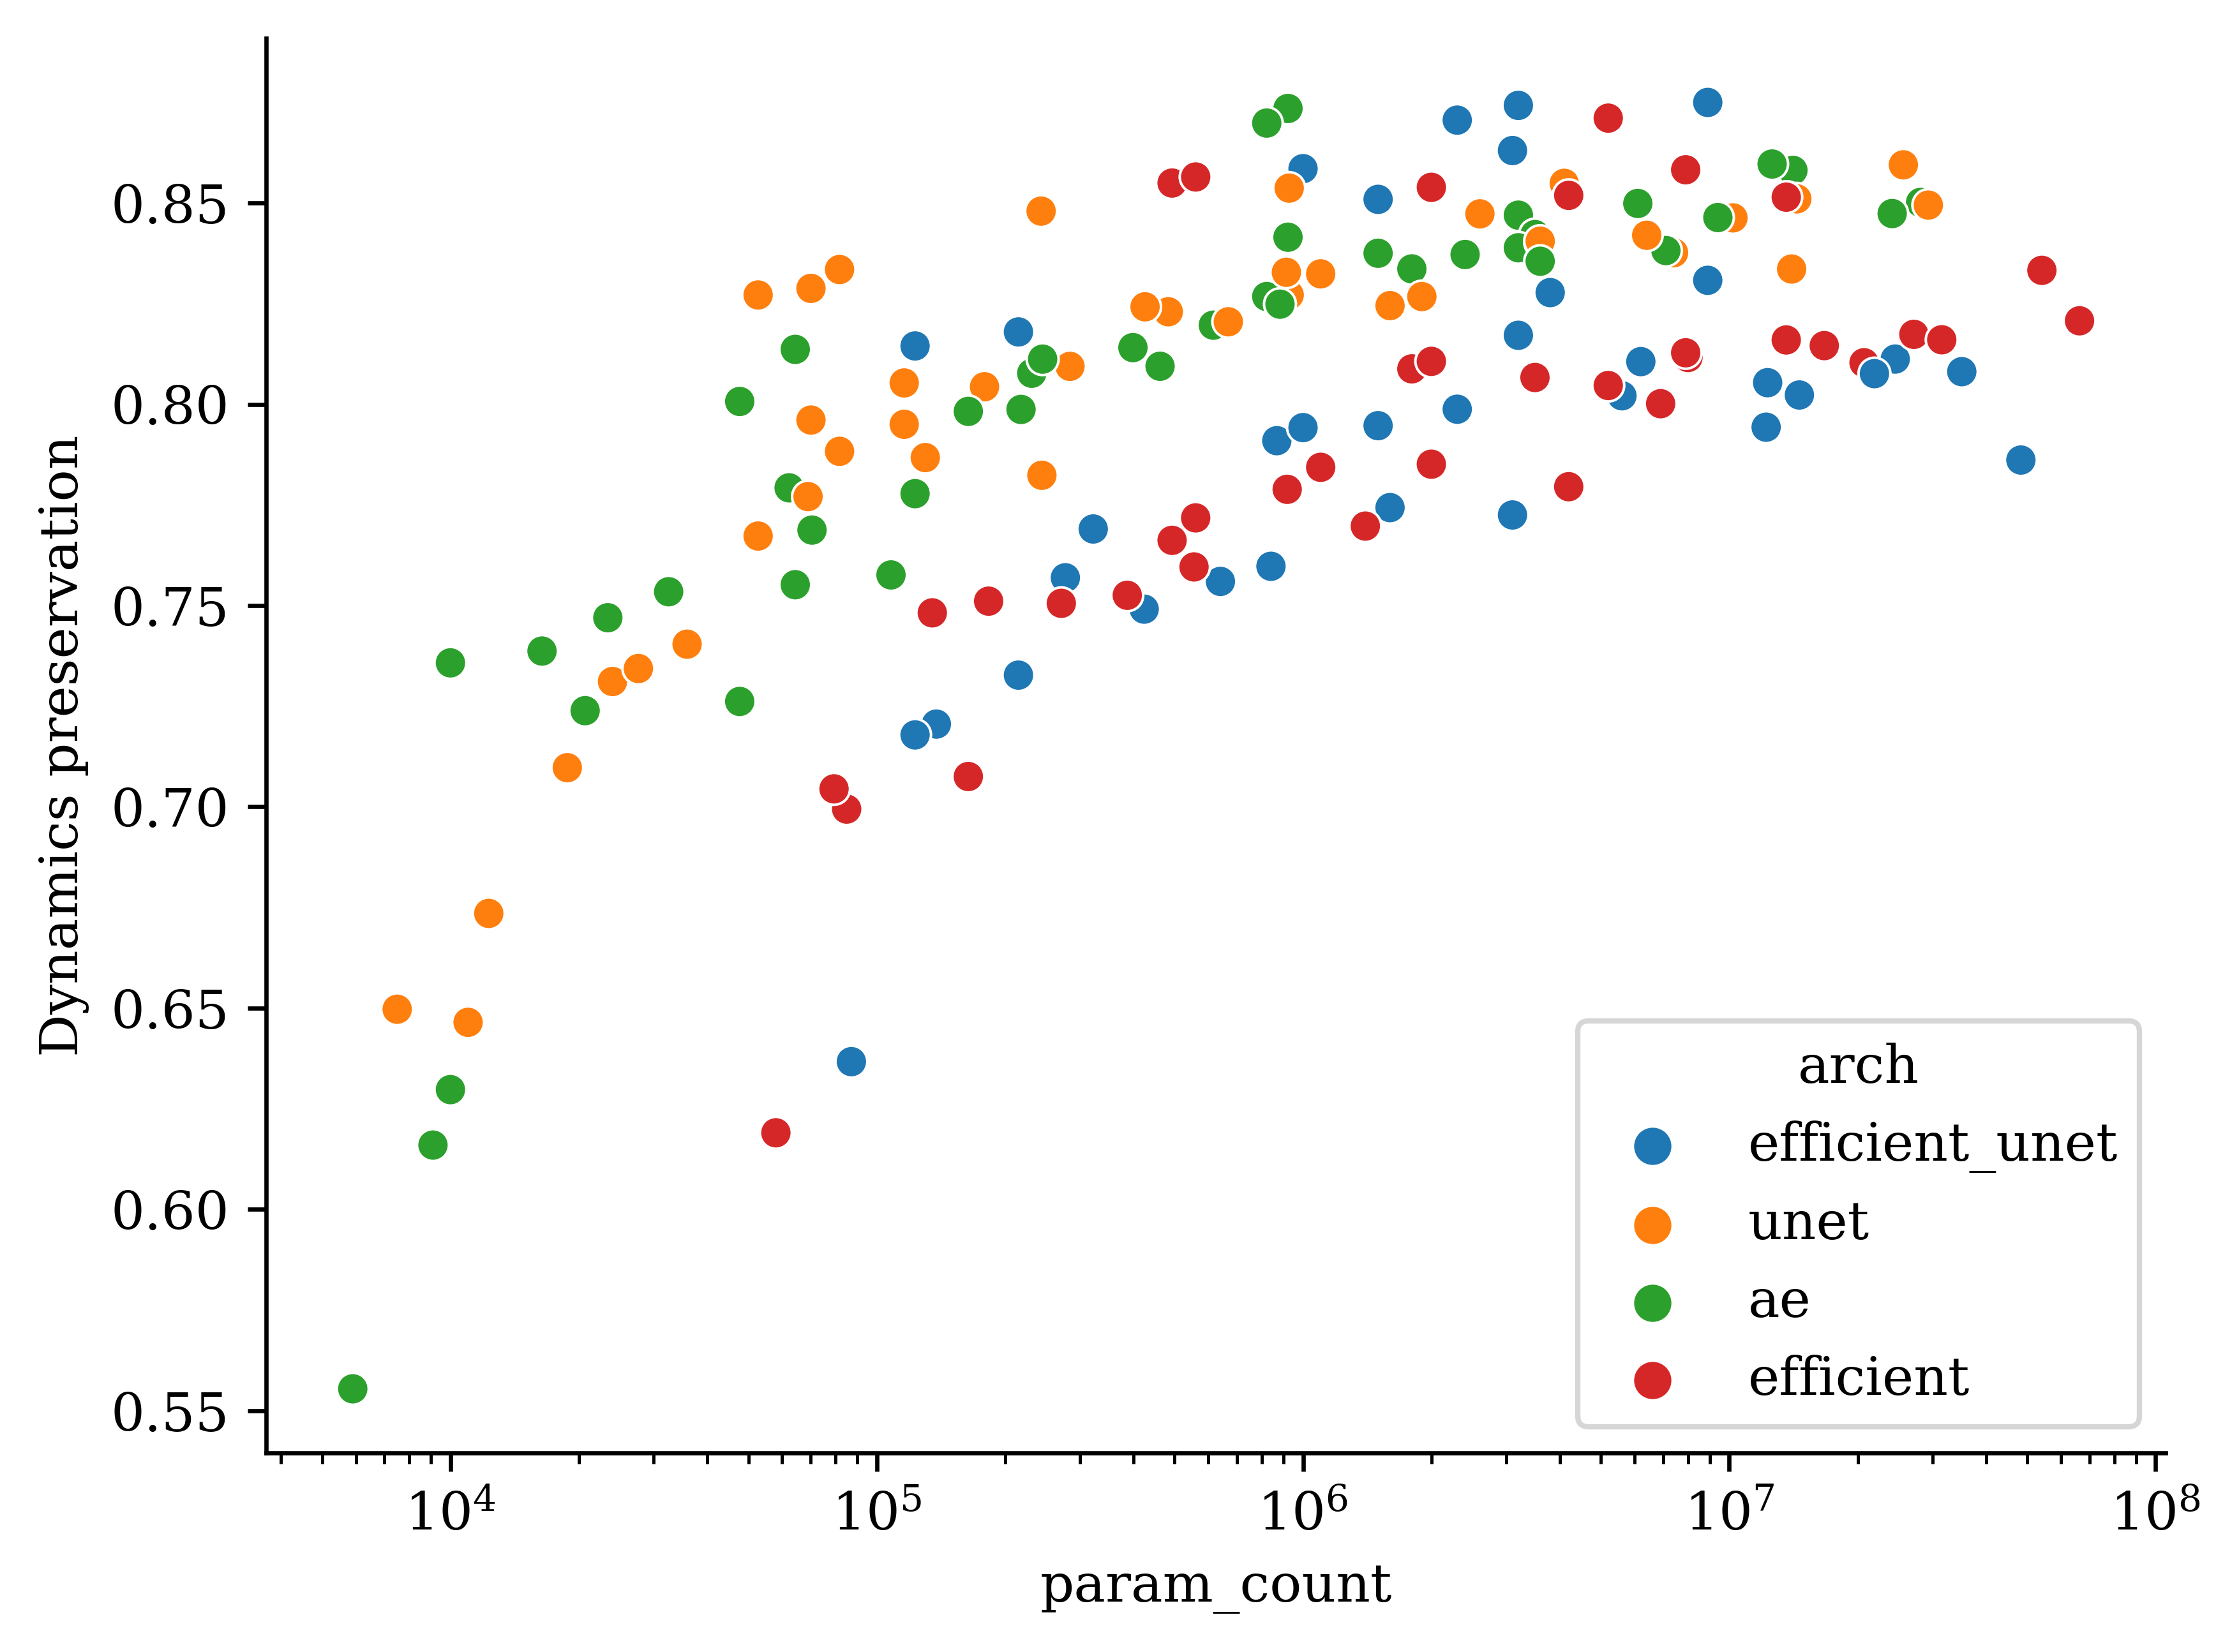

In [81]:
ax = sns.scatterplot(
    data=results.query("epoch == 100"), x="param_count", y="dynamics_corr", hue="arch"
)
ax.set(xscale="log", ylabel="Dynamics preservation")
sns.despine()

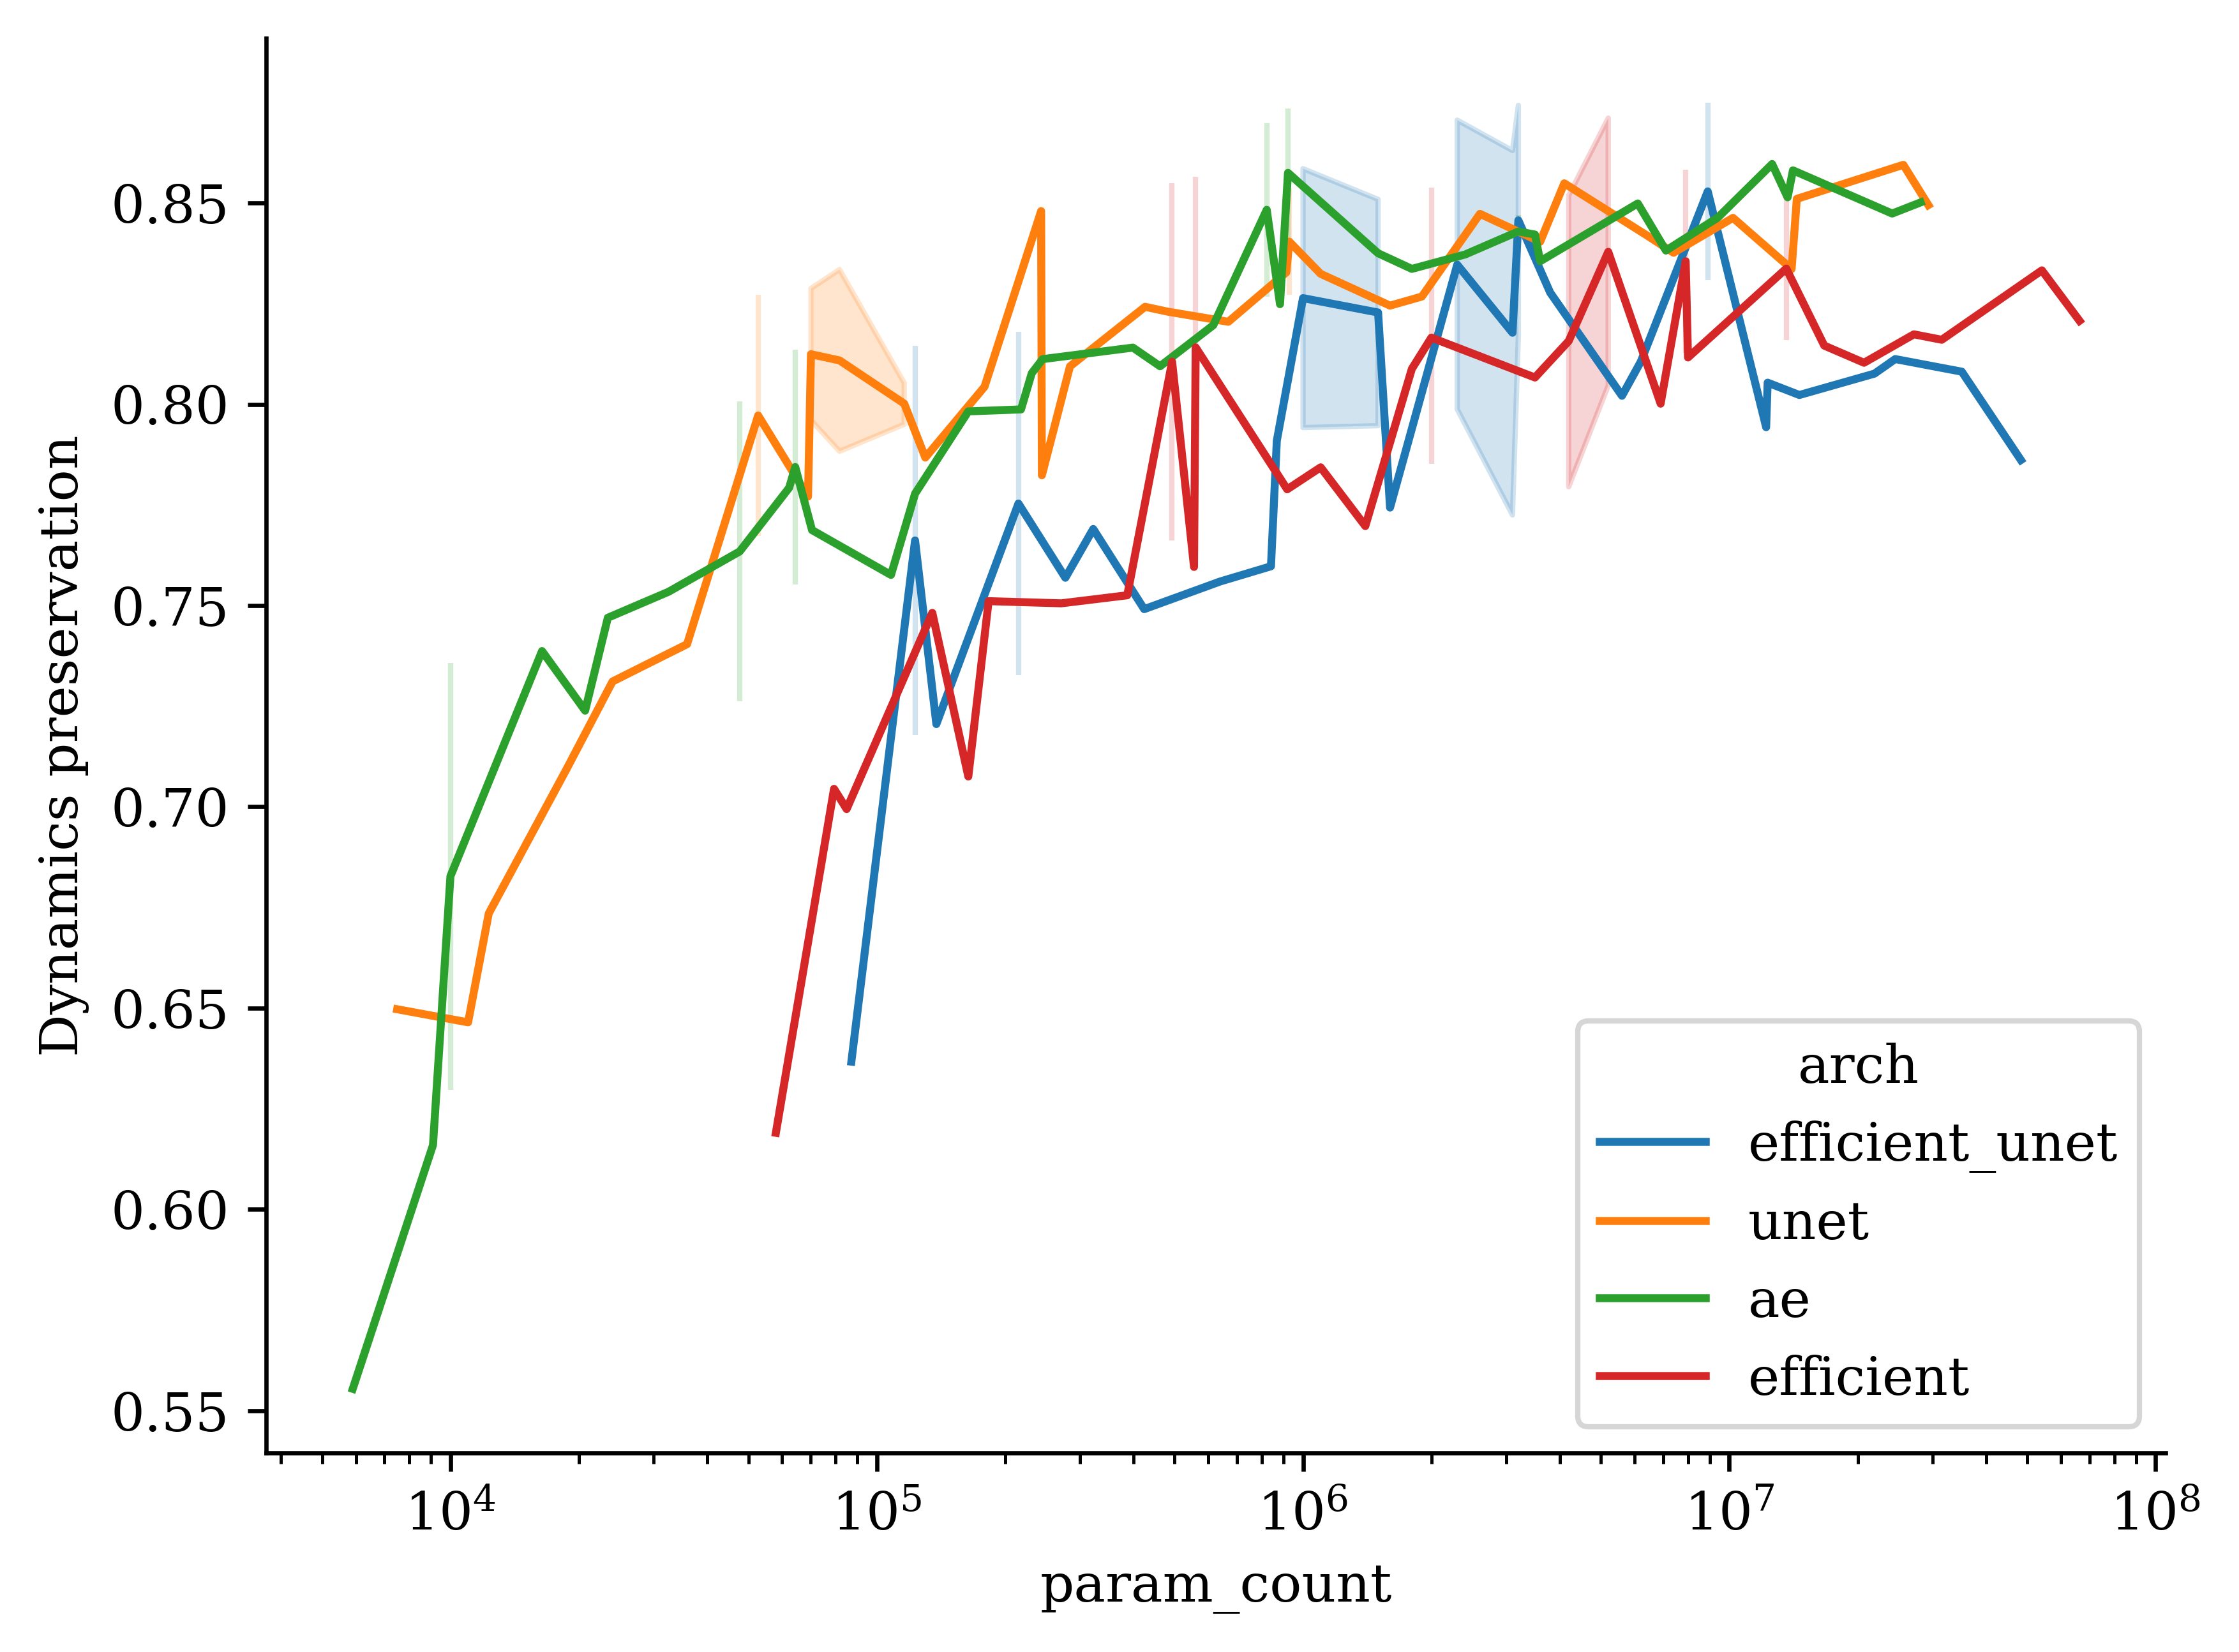

In [82]:
ax = sns.lineplot(
    data=results.query("epoch == 100"), x="param_count", y="dynamics_corr", hue="arch"
)
ax.set(xscale="log", ylabel="Dynamics preservation")
sns.despine()

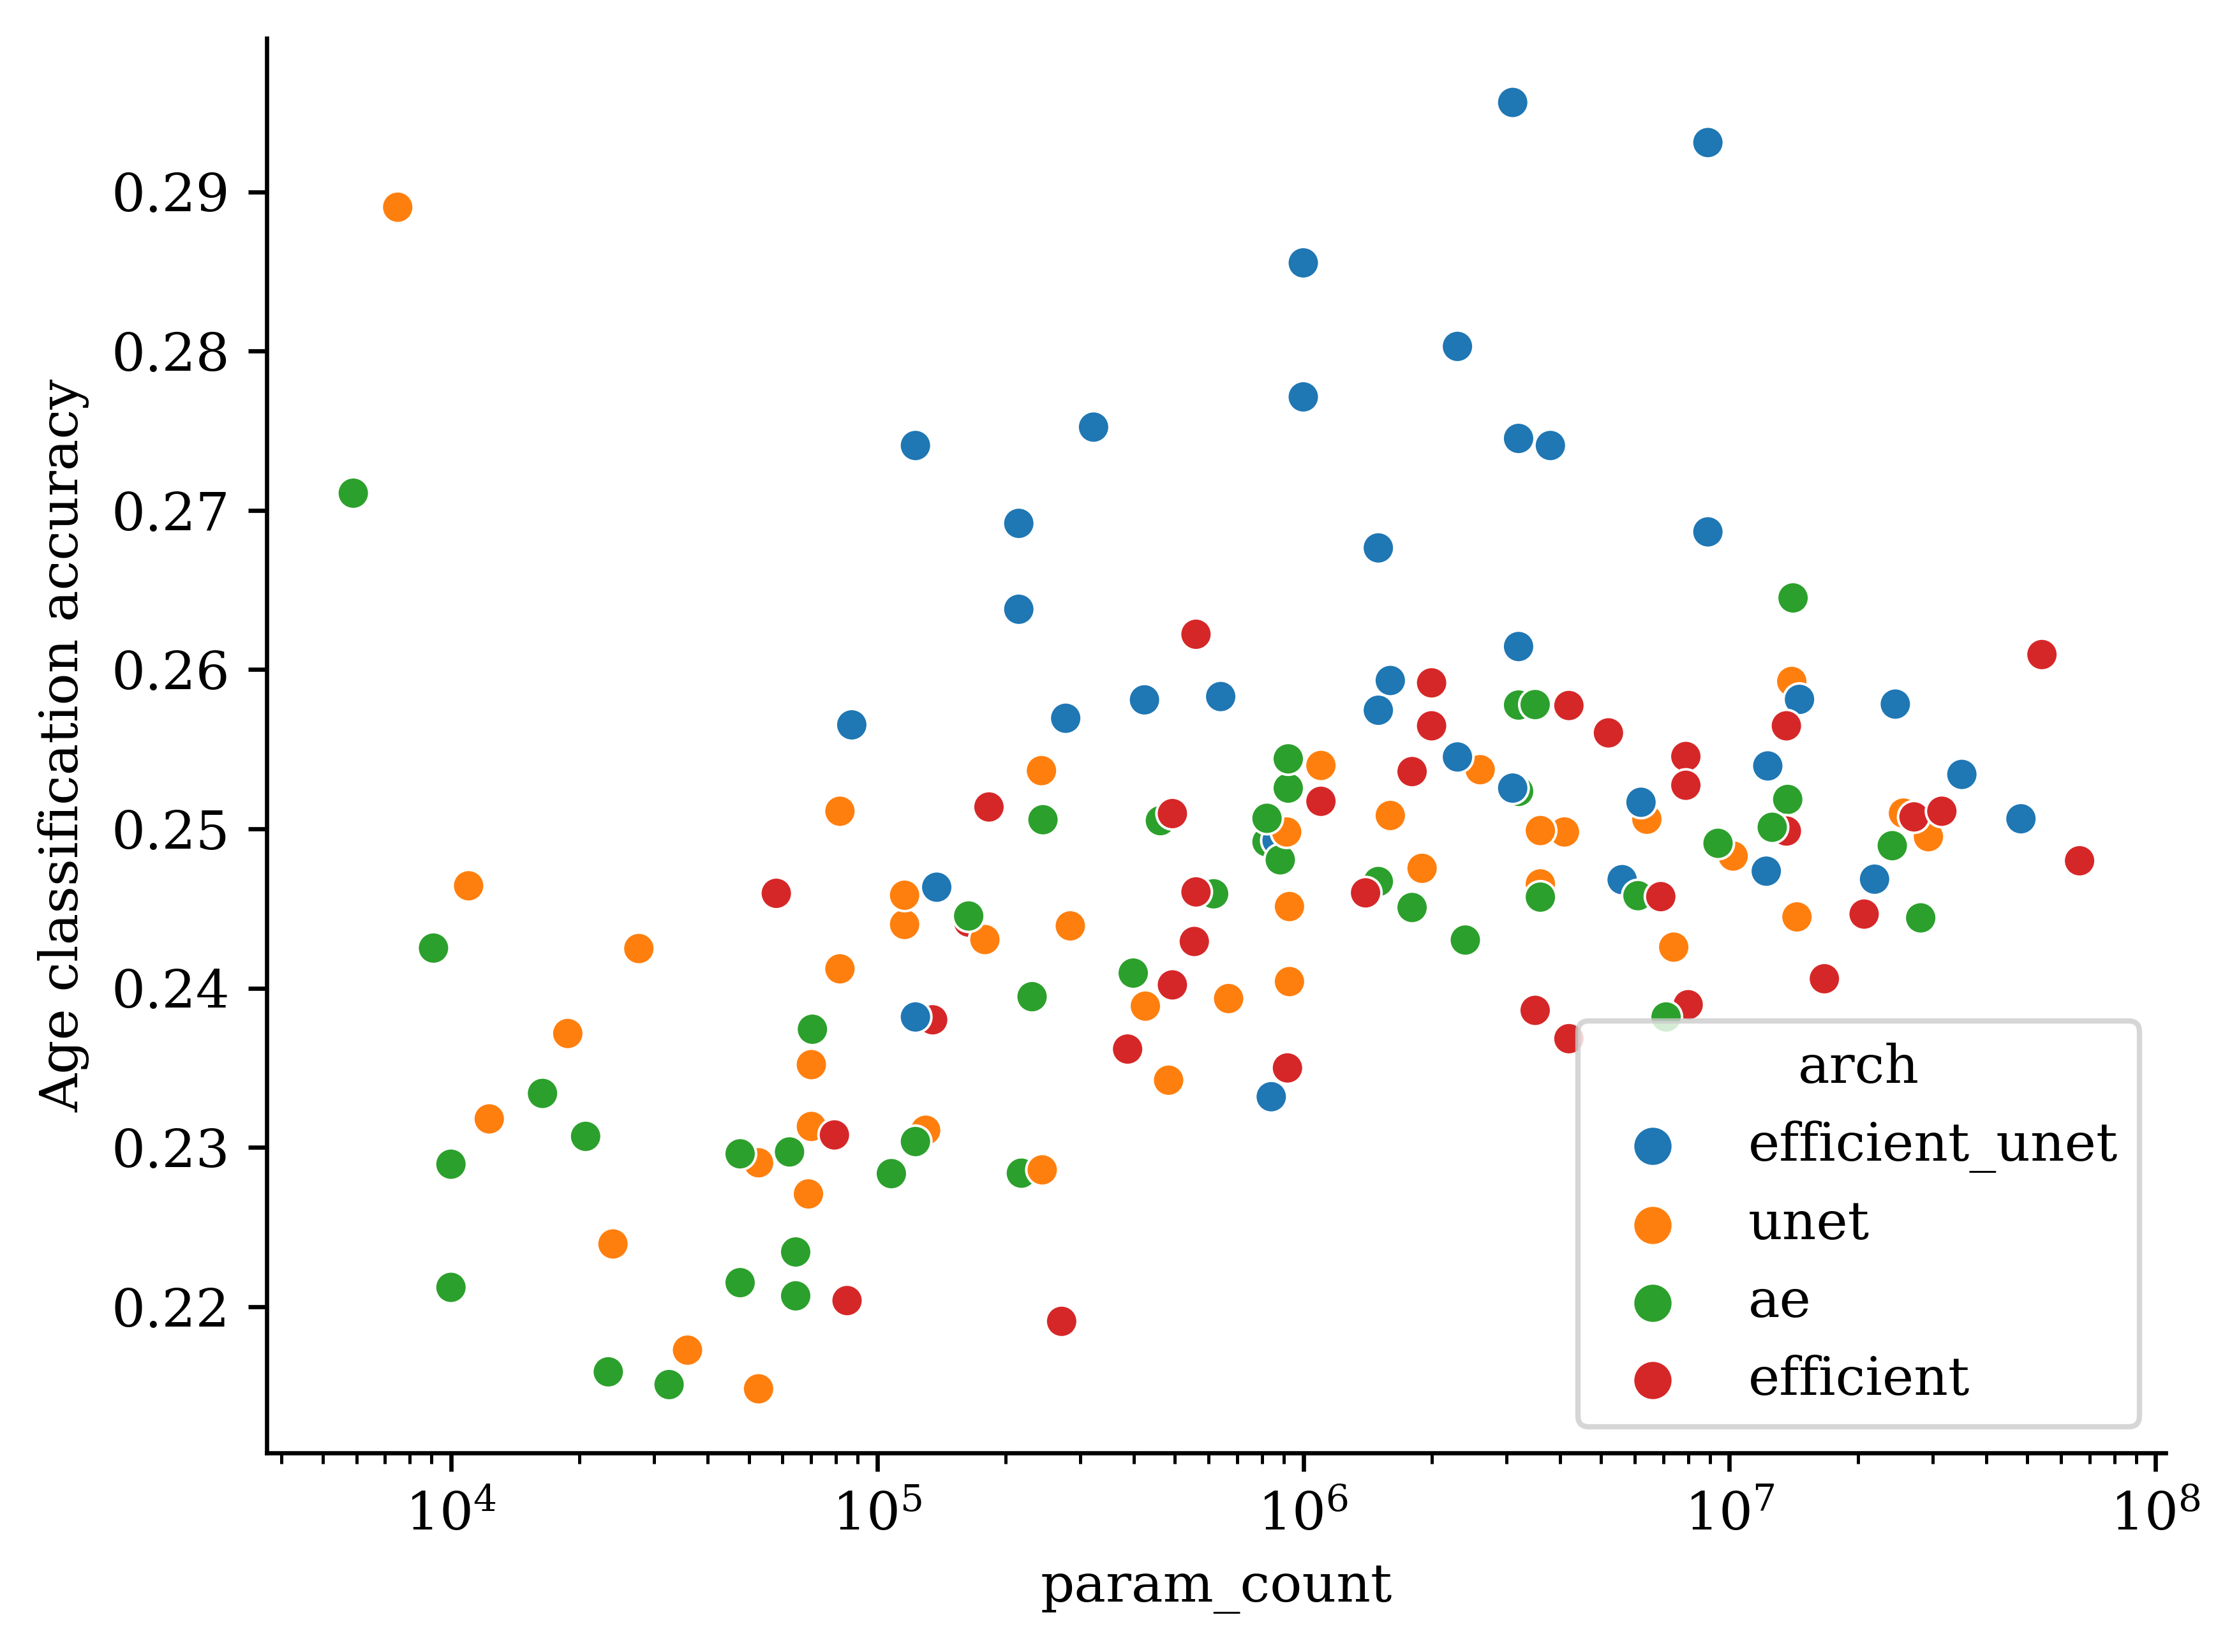

In [83]:
ax = sns.scatterplot(
    data=results.query("epoch == 100"), x="param_count", y="age_class", hue="arch"
)
ax.set(xscale="log", ylabel="Age classification accuracy")
sns.despine()

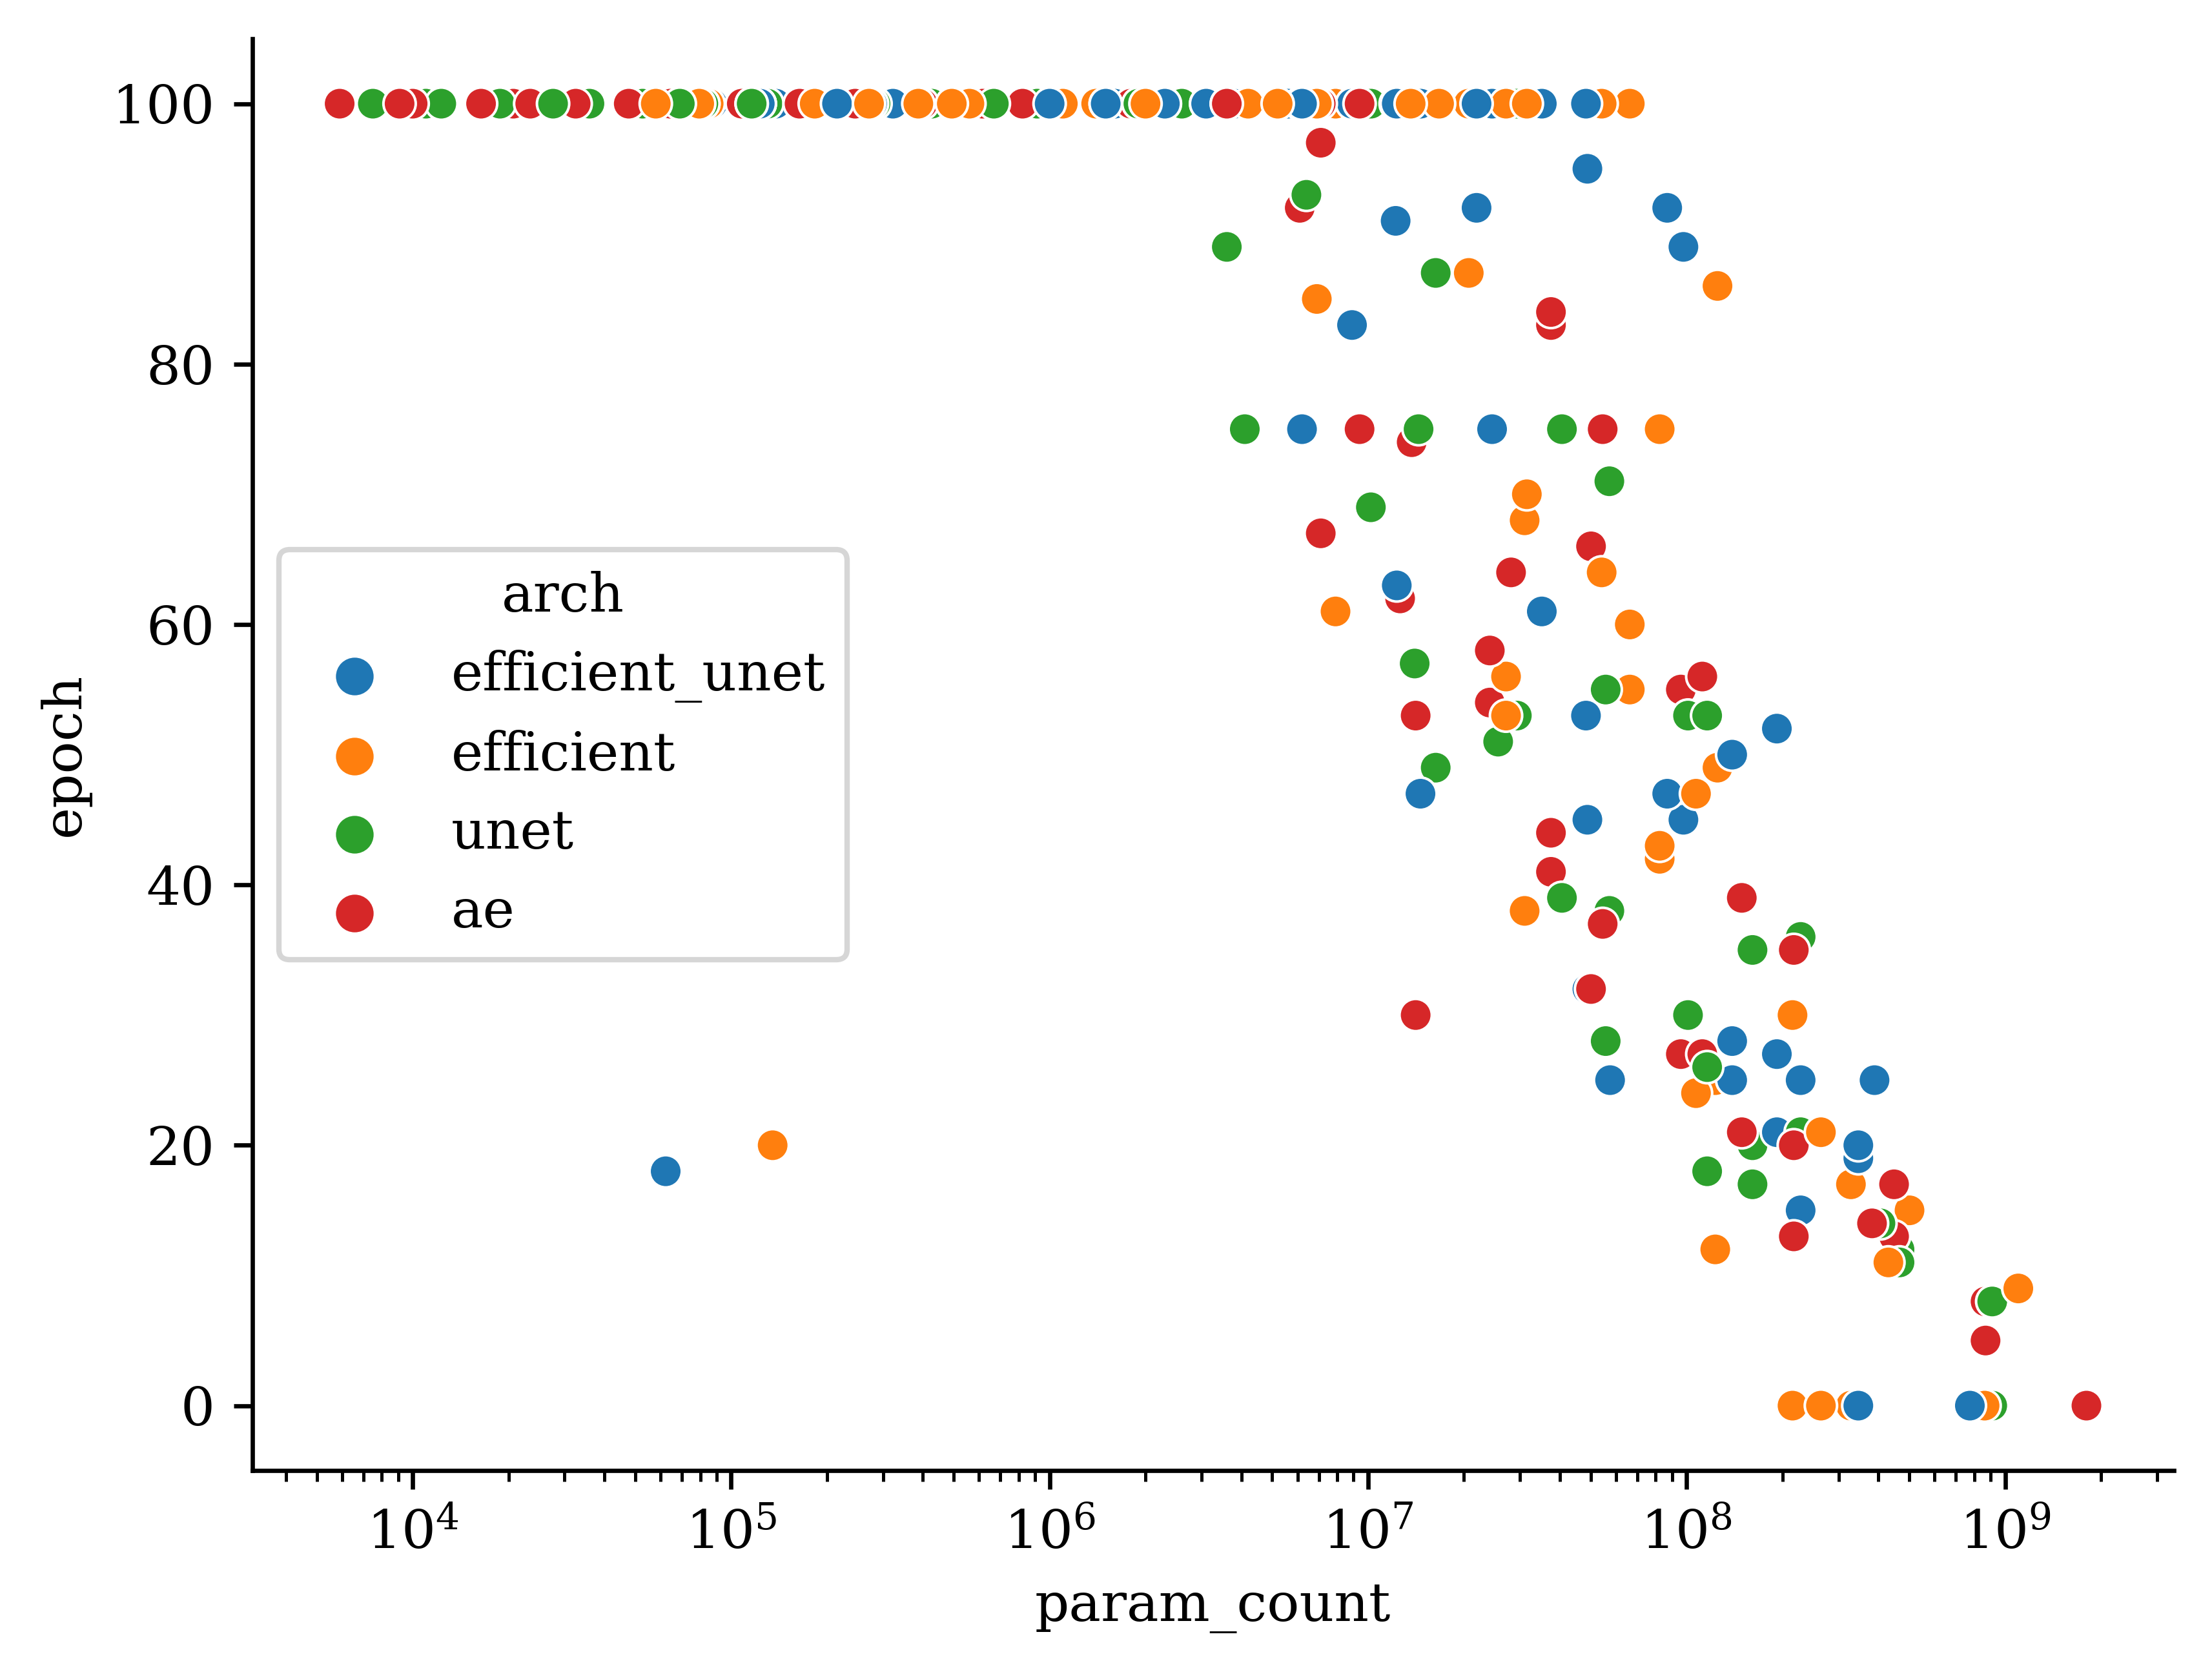

In [84]:
ax = sns.scatterplot(data=results, x='param_count', y='epoch', hue='arch')
ax.set(xscale='log')
sns.despine()

In [93]:
comp = results.query('epoch == 100').groupby(['init_channel', 'arch', 'channel_scaling']).mean(numeric_only=True)
comp['dyn_loss'] = 1 - comp['dynamics_corr']
comp['total_loss'] = comp['val_mse'] + (2e-3 * comp['dyn_loss']) + (1e-3 * comp['age_class'])

In [94]:
comp.sort_values(by='total_loss').head(10)

depth  depth_scaling  init_depth   val_mse  \
init_channel arch channel_scaling                                               
256          ae   2.0                4.0            1.0         1.0  0.000527   
512          ae   1.5                4.0            1.0         1.0  0.000513   
64           ae   4.0                4.0            1.0         1.0  0.000526   
128          unet 3.0                4.0            1.0         1.0  0.000539   
             ae   3.0                4.0            1.0         1.0  0.000519   
                  2.5                4.0            1.0         1.0  0.000528   
64           unet 3.5                4.0            1.0         1.0  0.000542   
256          unet 1.5                4.0            1.0         1.0  0.000548   
64           ae   3.5                4.0            1.0         1.0  0.000543   
             unet 4.0                4.0            1.0         1.0  0.000543   

                                   train_mse  epoch  param_count  \
init_channel arch channel_scaling                                  
256          ae   2.0               0.000490  100.0   12600000.0   
512          ae   1.5               0.000461  100.0   14100000.0   
64           ae   4.0               0.000492  100.0   28100000.0   
128          unet 3.0               0.000483  100.0   25600000.0   
             ae   3.0               0.000485  100.0   24100000.0   
                  2.5               0.000477  100.0    9400000.0   
64           unet 3.5               0.000503  100.0   14400000.0   
256          unet 1.5               0.000510  100.0    4100000.0   
64           ae   3.5               0.000491  100.0   13700000.0   
             unet 4.0               0.000501  100.0   29300000.0   

                                   dynamics_corr  age_class  dyn_loss  \
init_channel arch channel_scaling                                       
256          ae   2.0                   0.859677   0.250104  0.140323   
512          ae   1.5                   0.858104   0.264504  0.141896   
64           ae   4.0                   0.850140   0.244415  0.149860   
128          unet 3.0                   0.859475   0.250993  0.140525   
             ae   3.0                   0.847373   0.248948  0.152627   
                  2.5                   0.846377   0.249096  0.153623   
64           unet 3.5                   0.851024   0.244474  0.148976   
256          unet 1.5                   0.854882   0.249807  0.145118   
64           ae   3.5                   0.851402   0.251852  0.148598   
             unet 4.0                   0.849474   0.249511  0.150526   

                                   total_loss  
init_channel arch channel_scaling              
256          ae   2.0                0.001057  
512          ae   1.5                0.001061  
64           ae   4.0                0.001070  
128          unet 3.0                0.001071  
             ae   3.0                0.001073  
                  2.5                0.001085  
64           unet 3.5                0.001085  
256          unet 1.5                0.001088  
64           ae   3.5                0.001092  
             unet 4.0                0.001093

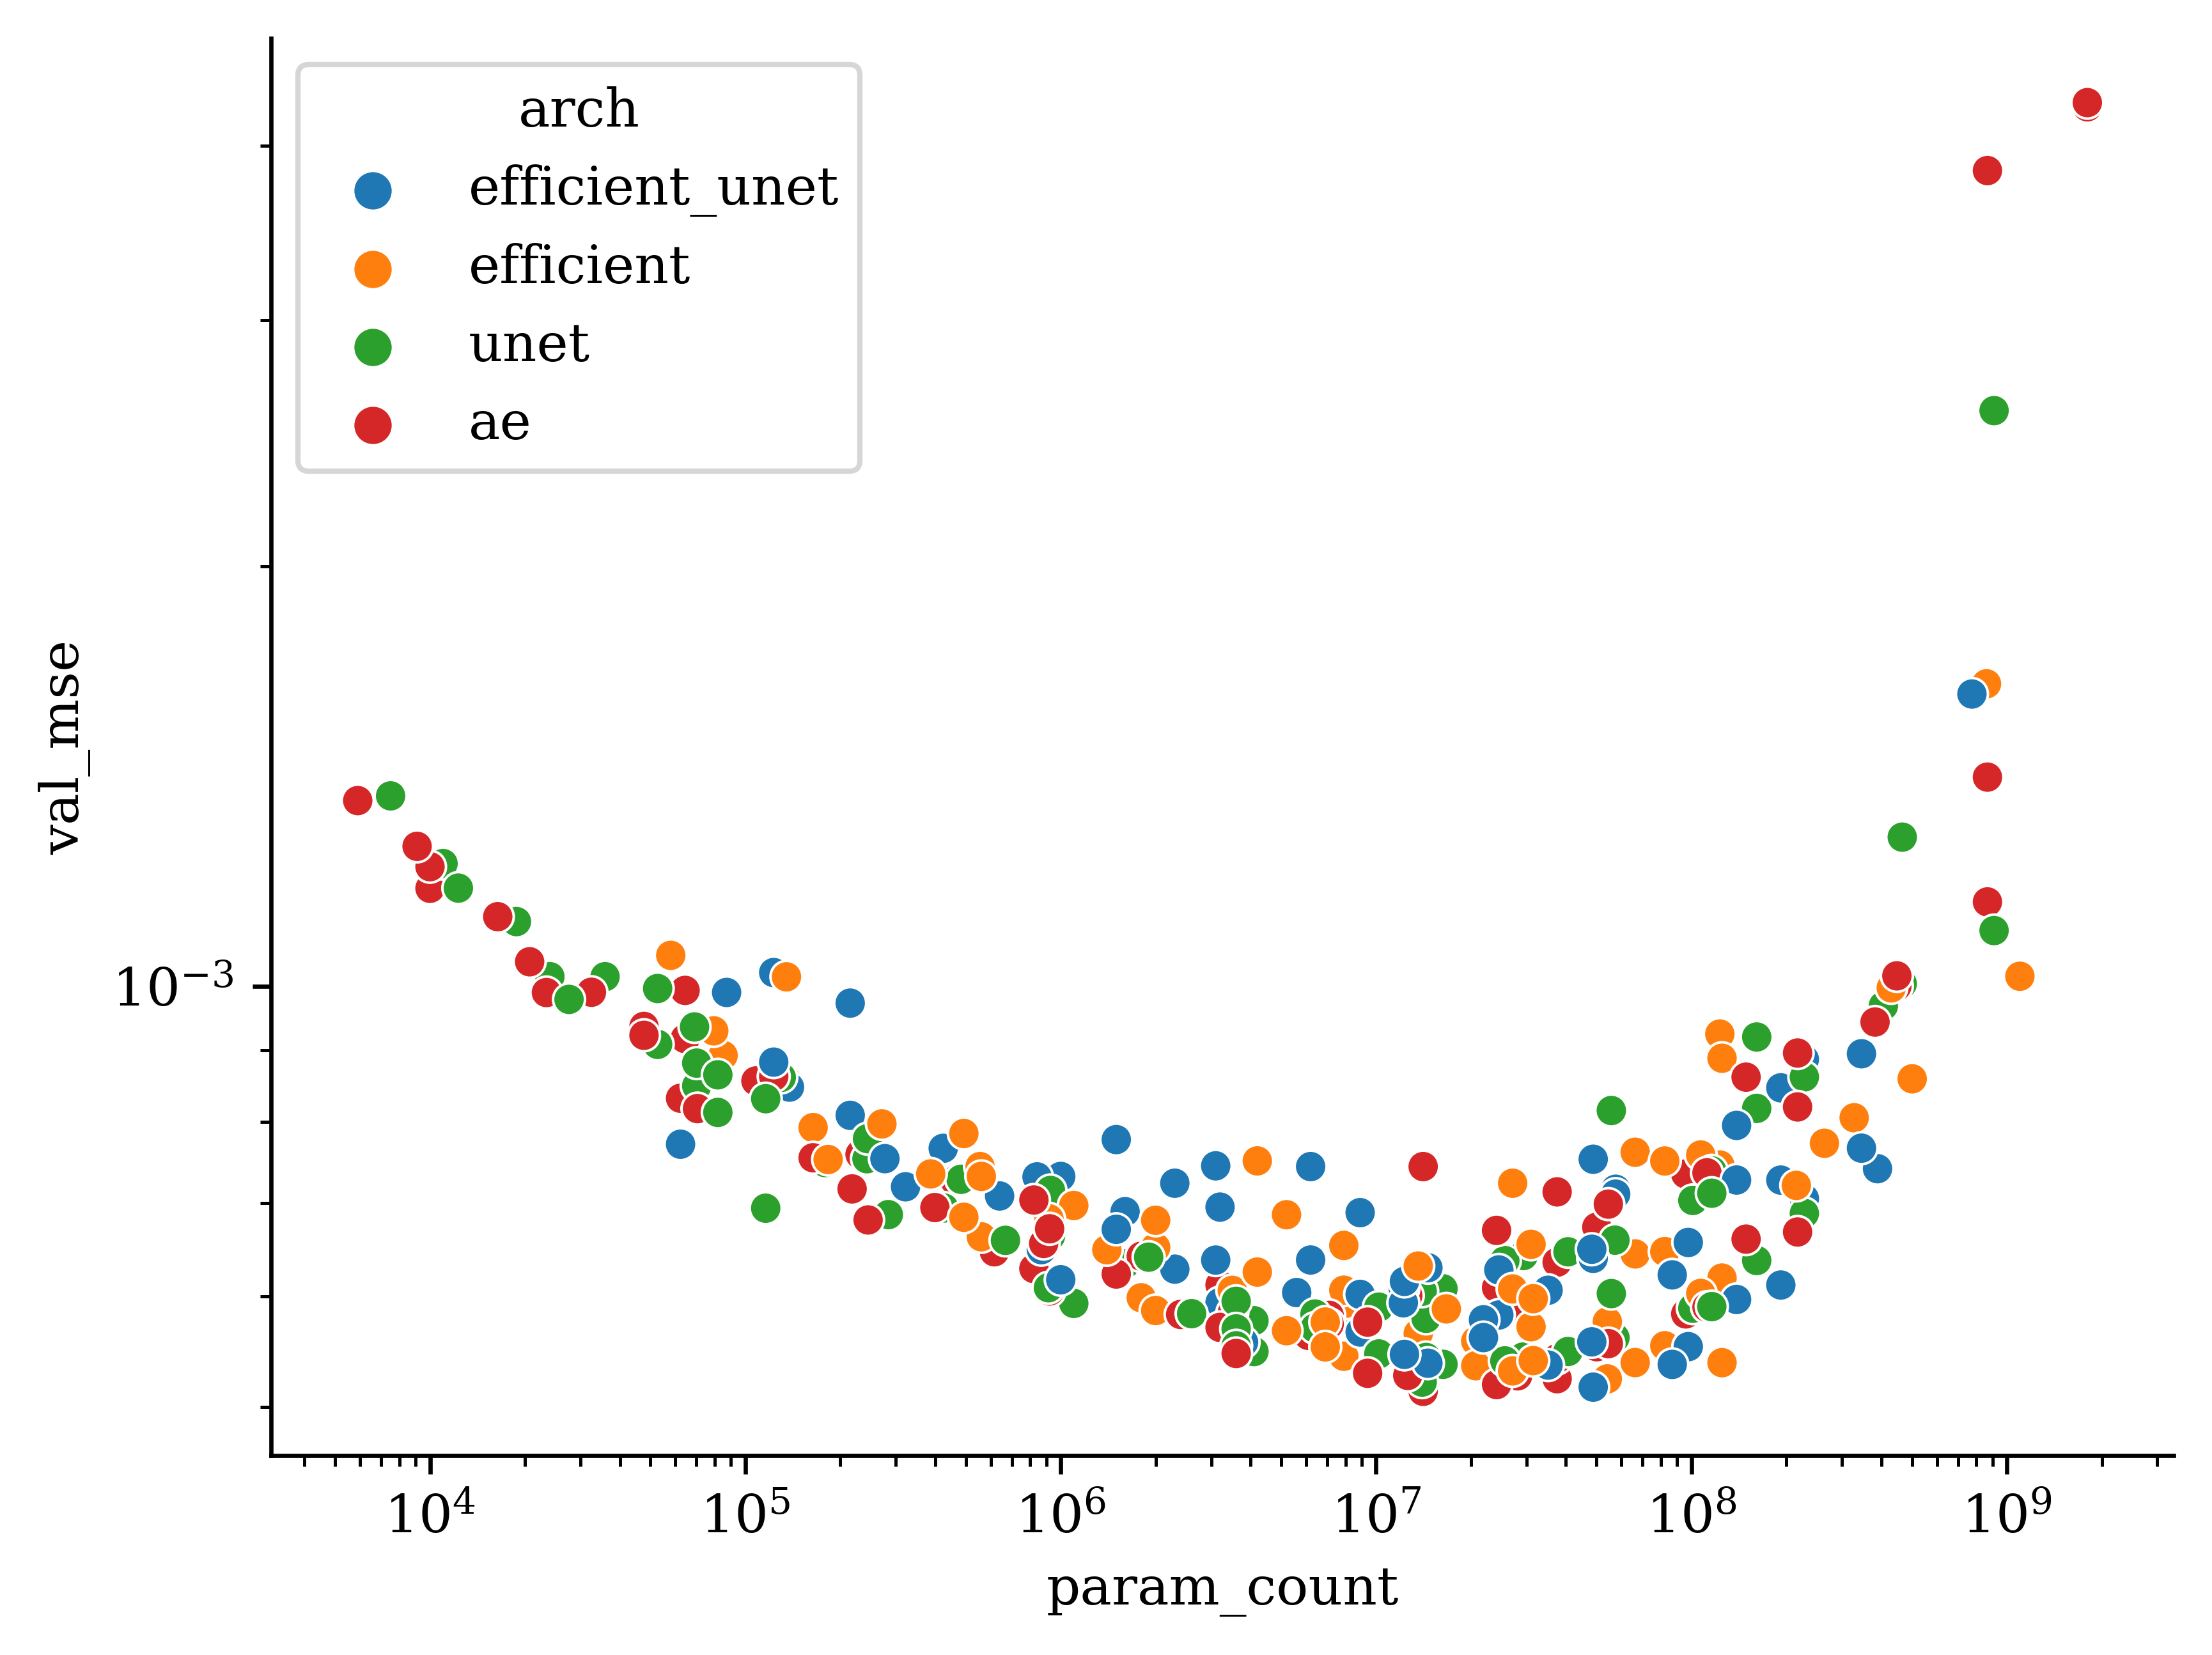

In [92]:
ax = sns.scatterplot(data=results, x='param_count', y='val_mse', hue='arch')
ax.set(xscale='log', yscale='log')
sns.despine()

In [26]:
results.groupby(['init_channel', 'arch', 'channel_scaling'])['depth'].count().unique()

array([1, 2, 3])

## Observe output of big "final" model

In [2]:
import numpy as np

In [3]:
df = pd.concat([
    pd.read_csv('/n/groups/datta/win/longtogeny/size_norm/models/continuous-gradient-size-test-with-l2-2023-07-28/size_norm_scan/version_0/metrics.csv'),
    # pd.read_csv('/n/groups/datta/win/longtogeny/size_norm/models/continuous-gradient-size-test-2023-07-28/size_norm_scan/version_0/metrics.csv'),
    # pd.read_csv('/n/groups/datta/win/longtogeny/size_norm/models/pre_final_model-2023-07-27/size_norm_scan/version_0/metrics.csv'),
    # pd.read_csv('/n/groups/datta/win/longtogeny/size_norm/models/pre_final_model-2023-07-26/size_norm_scan/version_2/metrics.csv')
], ignore_index=True)

In [4]:
df.head()

train_loss  90th_percentile_weight_sn  sn_l2_loss   sn_norm  epoch  step  \
0    0.109297                   0.070915   51.393505  2.792308      0    49   
1    0.043051                   0.071330   51.527824  2.480310      0    99   
2    0.013815                   0.071546   51.632282  3.344083      0   149   
3    0.004193                   0.072434   51.759647  3.455270      0   199   
4    0.002548                   0.074220   51.973850  4.915739      0   249   

   val_loss  class_loss  90th_percentile_weight_class  class_l2_loss  \
0       NaN         NaN                           NaN            NaN   
1       NaN         NaN                           NaN            NaN   
2       NaN         NaN                           NaN            NaN   
3       NaN         NaN                           NaN            NaN   
4       NaN         NaN                           NaN            NaN   

   class_norm  dynamics_correlation  age_classification  scale_factor  
0         NaN                   NaN                 NaN           NaN  
1         NaN                   NaN                 NaN           NaN  
2         NaN                   NaN                 NaN           NaN  
3         NaN                   NaN                 NaN           NaN  
4         NaN                   NaN                 NaN           NaN

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3605 entries, 0 to 3604
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   train_loss                    3243 non-null   float64
 1   90th_percentile_weight_sn     3243 non-null   float64
 2   sn_l2_loss                    3243 non-null   float64
 3   sn_norm                       3243 non-null   float64
 4   epoch                         3605 non-null   int64  
 5   step                          3605 non-null   int64  
 6   val_loss                      351 non-null    float64
 7   class_loss                    2966 non-null   float64
 8   90th_percentile_weight_class  2966 non-null   float64
 9   class_l2_loss                 2966 non-null   float64
 10  class_norm                    2964 non-null   float64
 11  dynamics_correlation          11 non-null     float64
 12  age_classification            11 non-null     float64
 13  sca

In [6]:
df['val_loss'].min()

0.0006191619322635

In [7]:
df['epoch'].max()

350

<Axes: xlabel='epoch'>

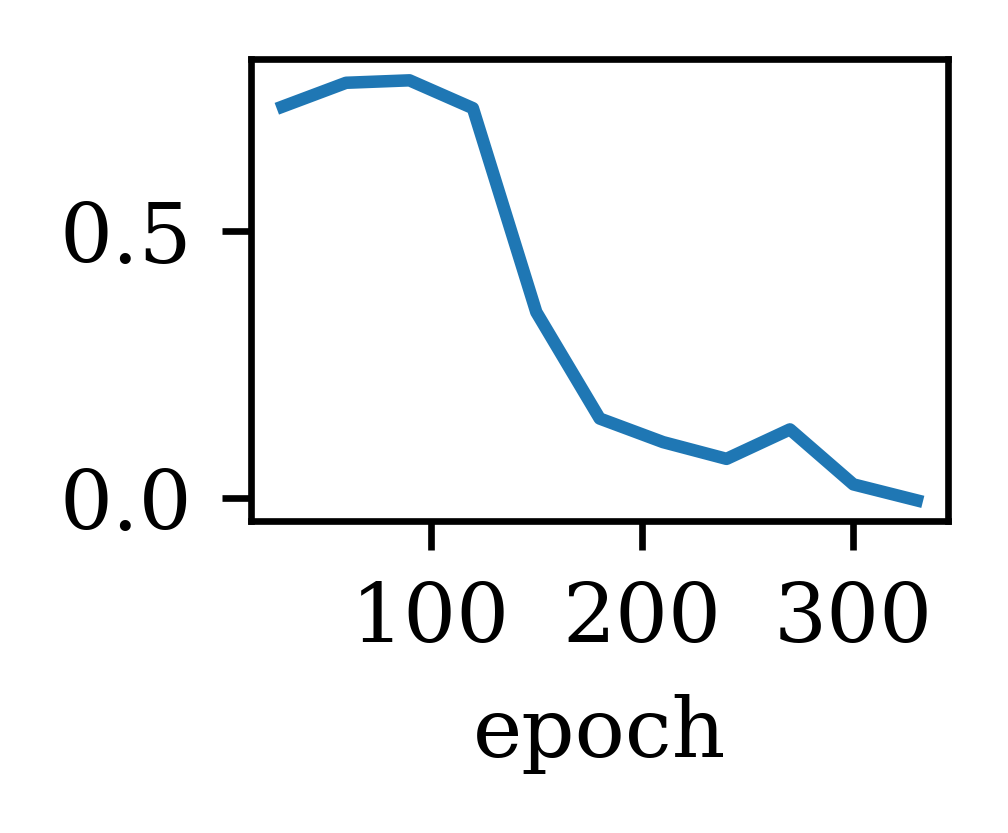

In [19]:
df.groupby('epoch')['dynamics_correlation'].mean().dropna().plot(figsize=(1.5, 1))

<Axes: xlabel='epoch'>

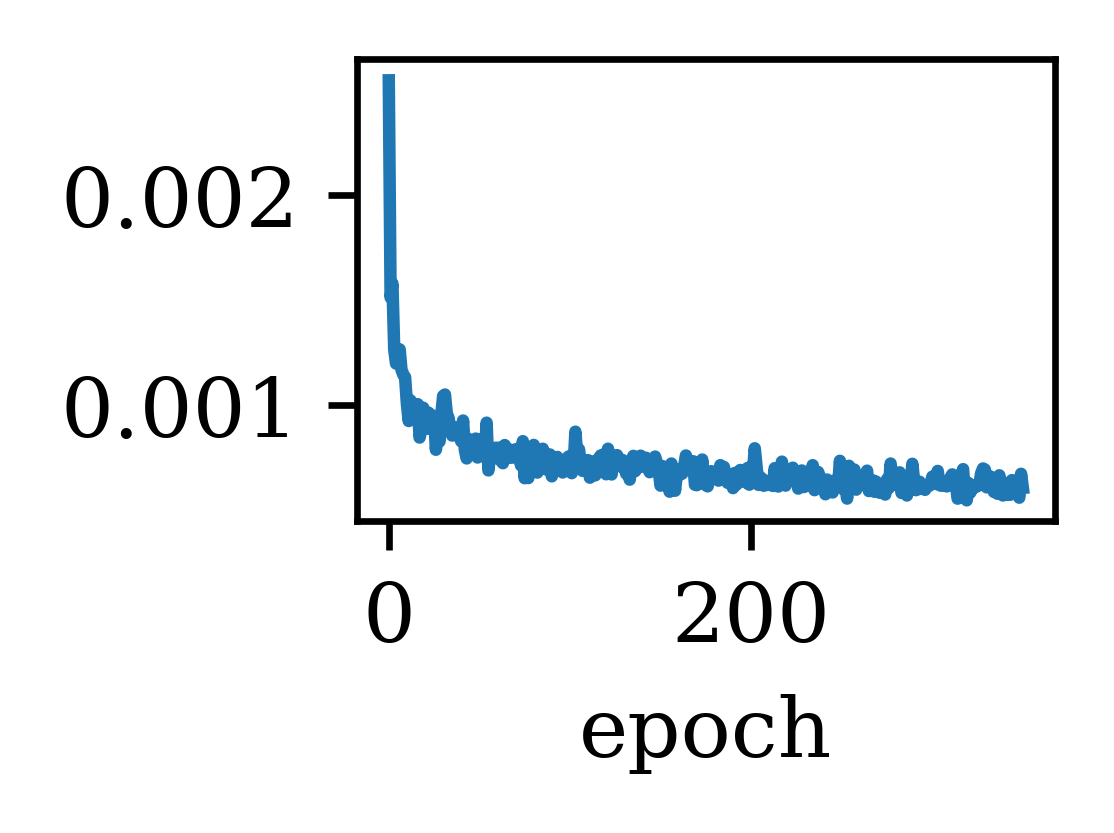

In [9]:
df.groupby('epoch')['train_loss'].median().plot(figsize=(1.5, 1))

In [22]:
df['age_classification'].min()

0.1744

<Axes: xlabel='epoch'>

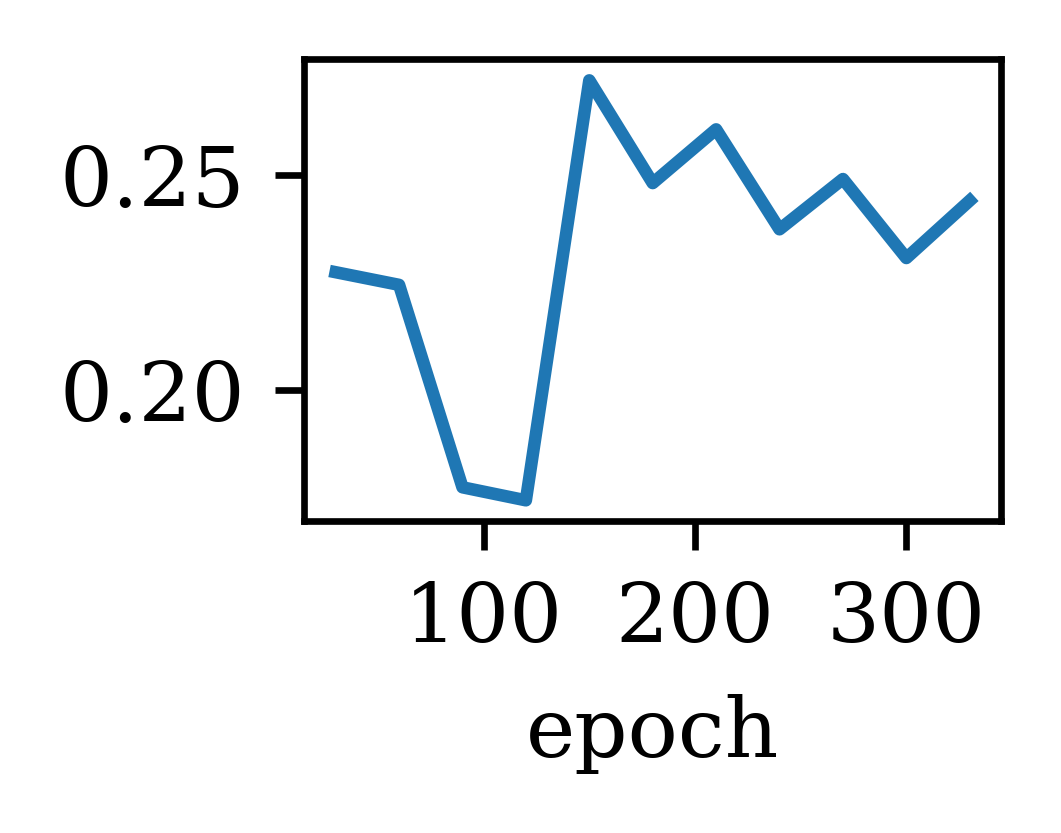

In [20]:
df.groupby('epoch')['age_classification'].mean().dropna().plot(figsize=(1.5, 1))

In [11]:
# df.groupby('epoch').mean(numeric_only=True)['class_acc'].plot()

<Axes: >

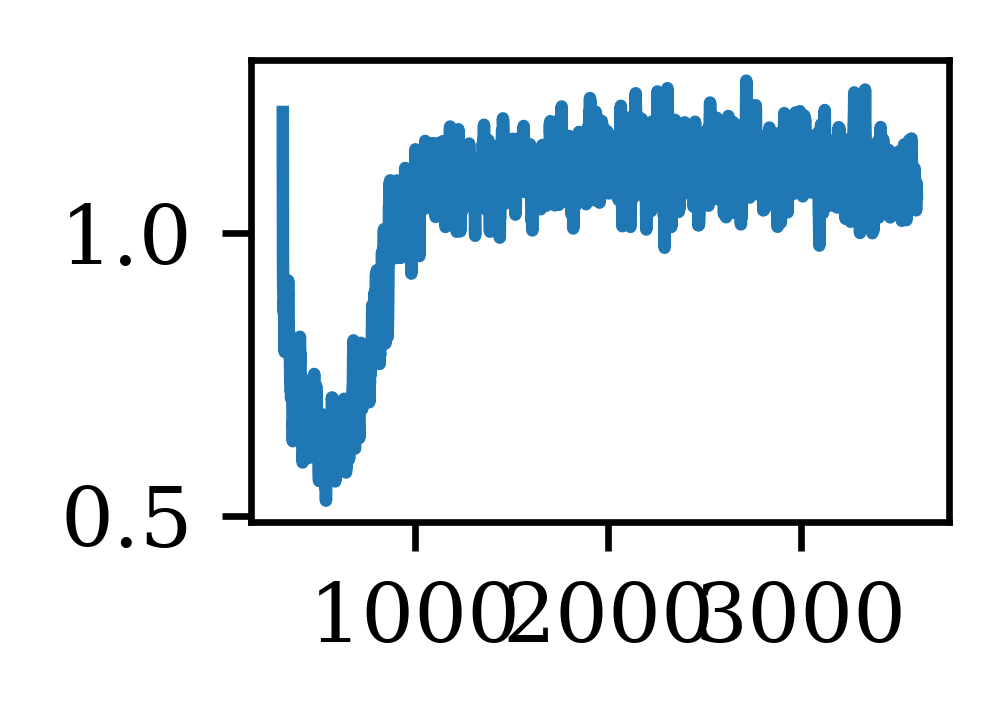

In [12]:
df['class_loss'].dropna().rolling(7).mean().plot(figsize=(1.5, 1))

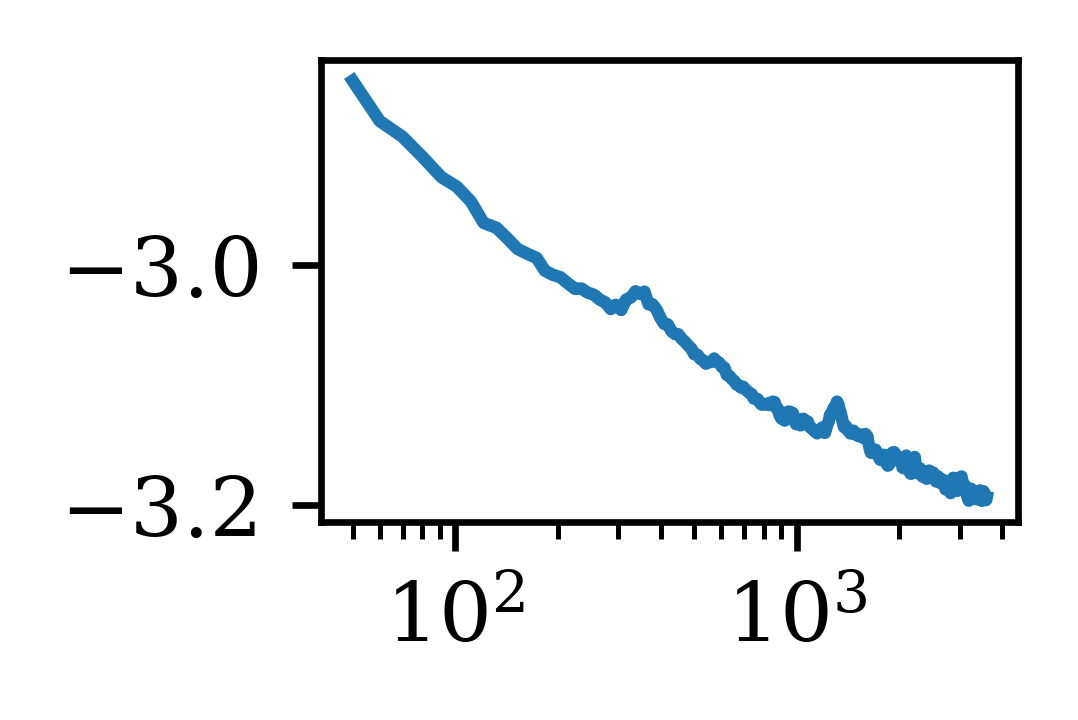

In [13]:
ax = np.log10(df['val_loss'].dropna().rolling(5).mean()).plot(figsize=(1.5, 1))
ax.set_xscale('log')

<Axes: xlabel='epoch'>

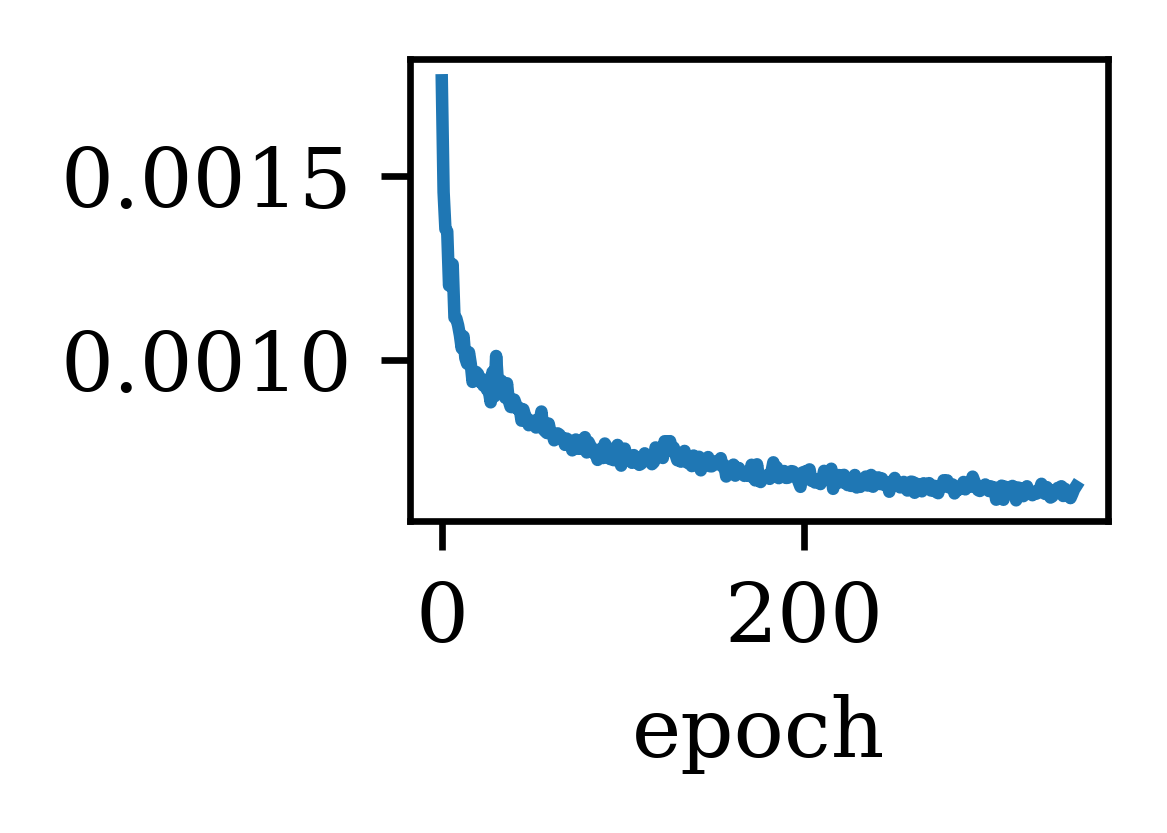

In [14]:
df.groupby('epoch').mean()['val_loss'].plot(figsize=(1.5, 1))

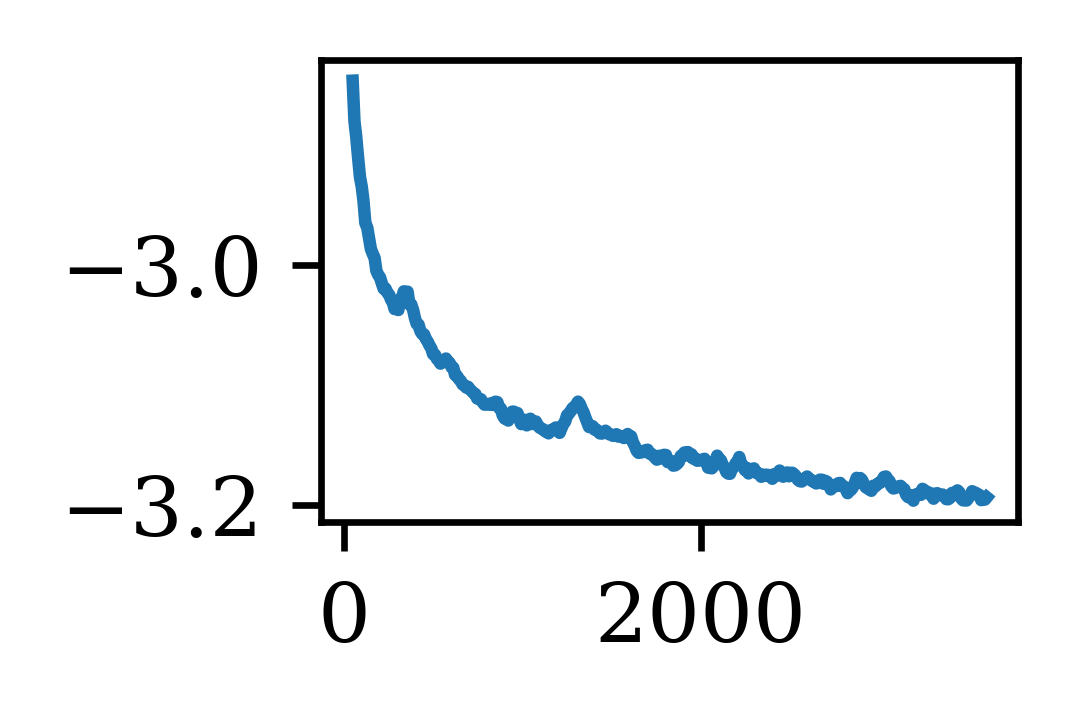

In [15]:
ax = np.log10(df['val_loss'].dropna().rolling(5).mean()).plot(figsize=(1.5, 1))
# ax.set_xscale('log')

<Axes: xlabel='epoch'>

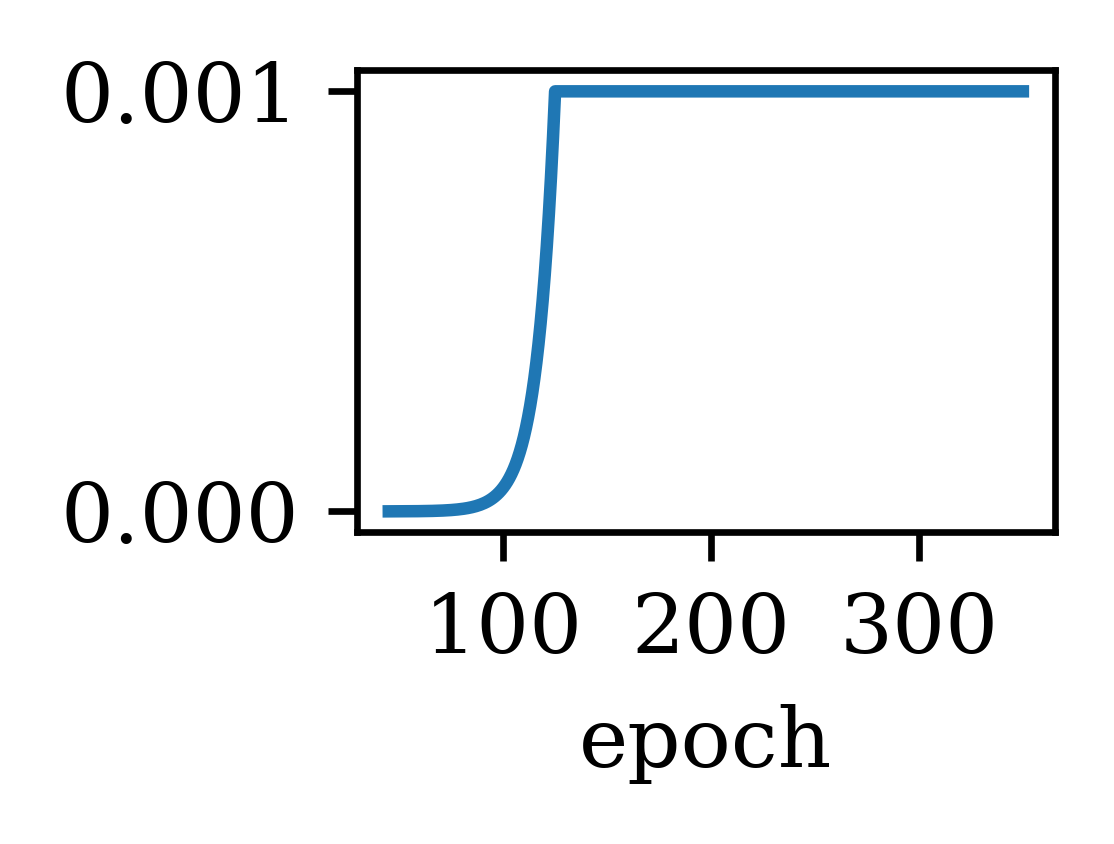

In [21]:
df.groupby('epoch')['scale_factor'].mean().dropna().plot(figsize=(1.5, 1))

<Axes: >

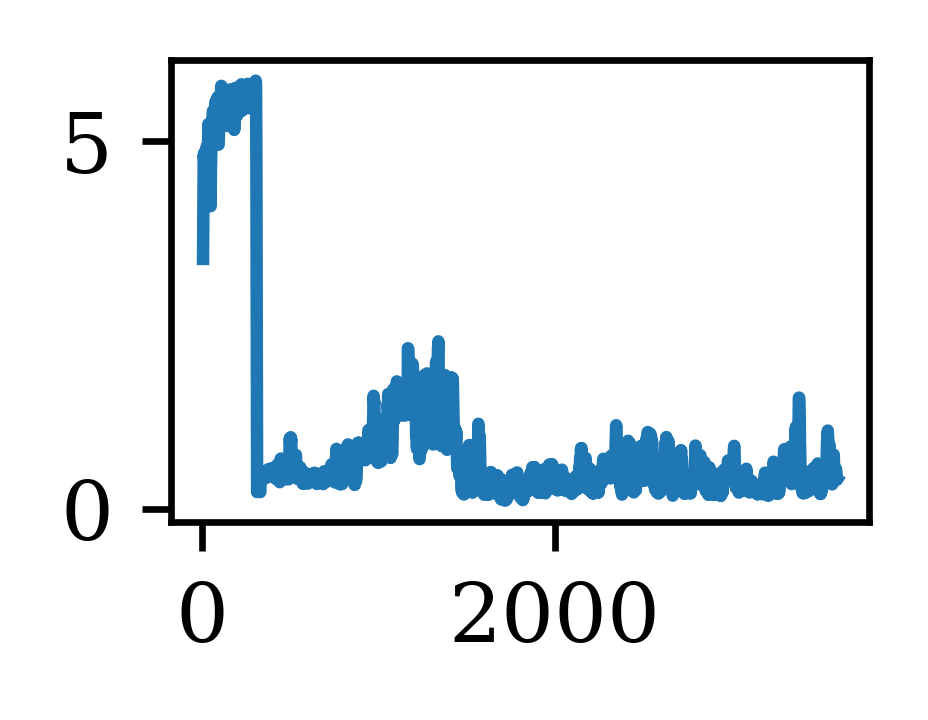

In [17]:
df['sn_norm'].dropna().rolling(5).mean().plot(figsize=(1.5, 1))

<Axes: >

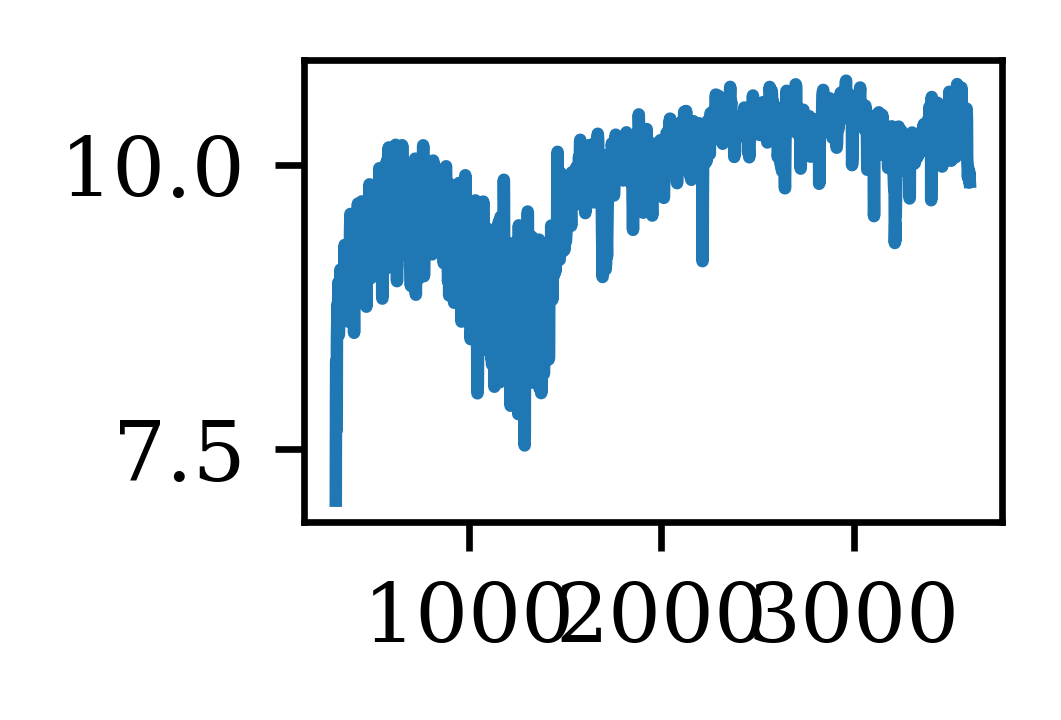

In [18]:
df['class_norm'].dropna().rolling(3).mean().plot(figsize=(1.5, 1))

[None]

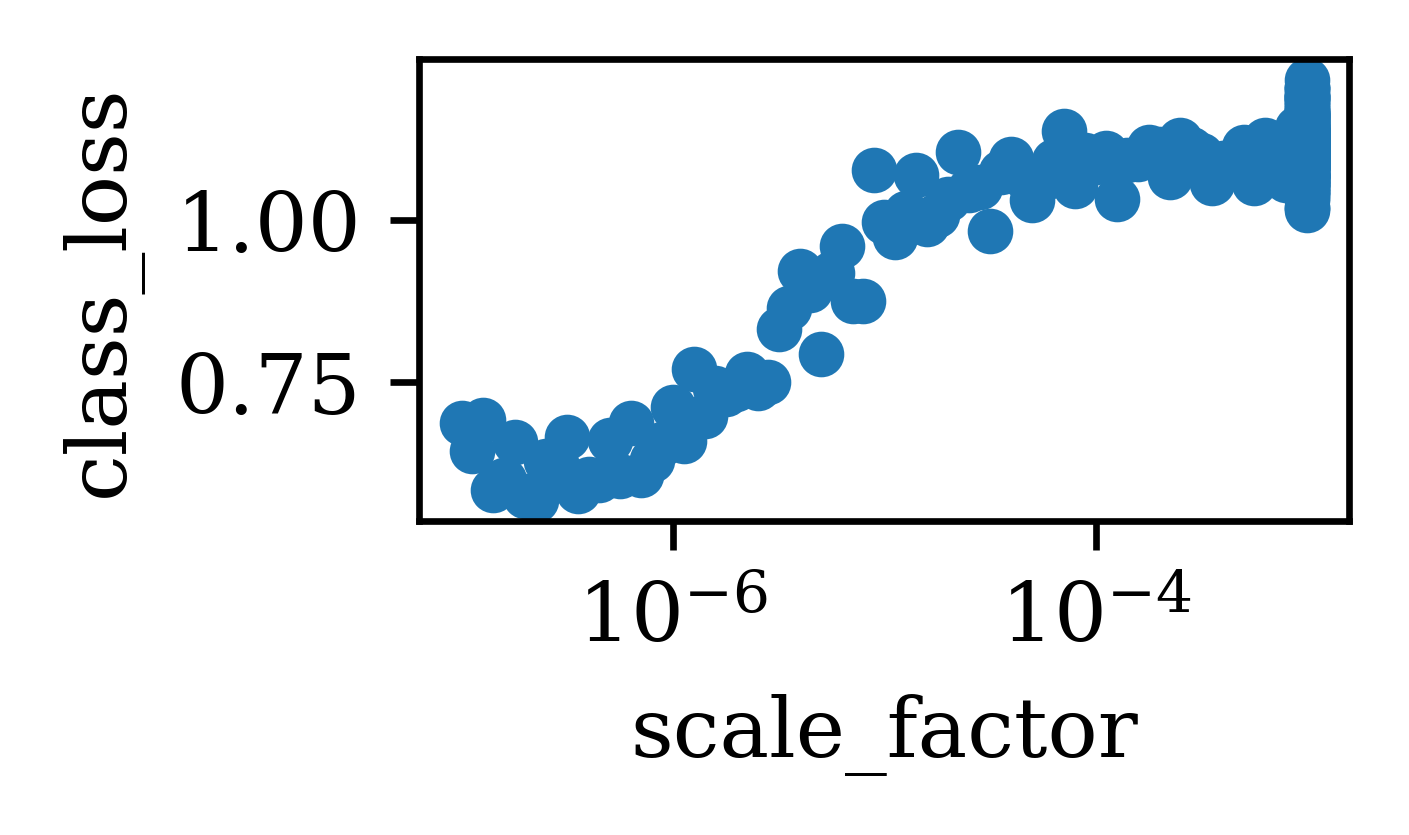

In [25]:
ax = df.groupby("epoch").mean().plot(
    kind="scatter", x="scale_factor", y="class_loss", figsize=(2, 1)
)
ax.set(xscale='log')

<Axes: xlabel='epoch'>

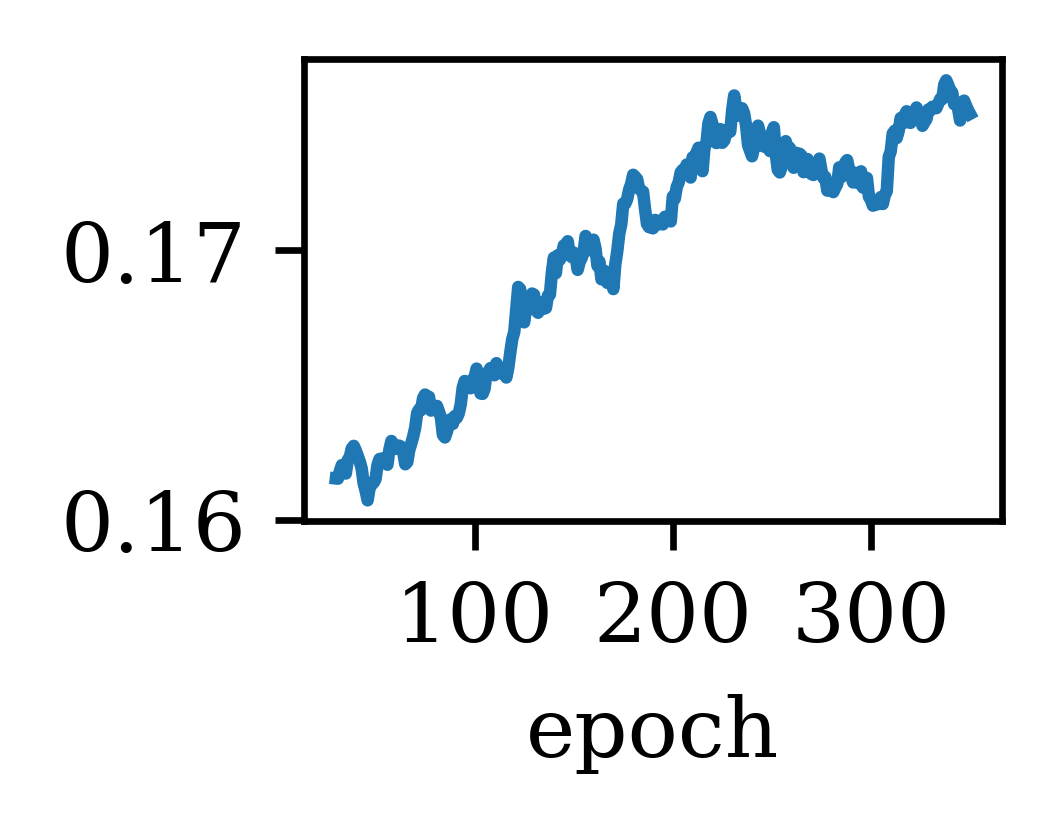

In [28]:
df.groupby('epoch')['90th_percentile_weight_class'].mean().dropna().plot(figsize=(1.5, 1))

<Axes: xlabel='epoch'>

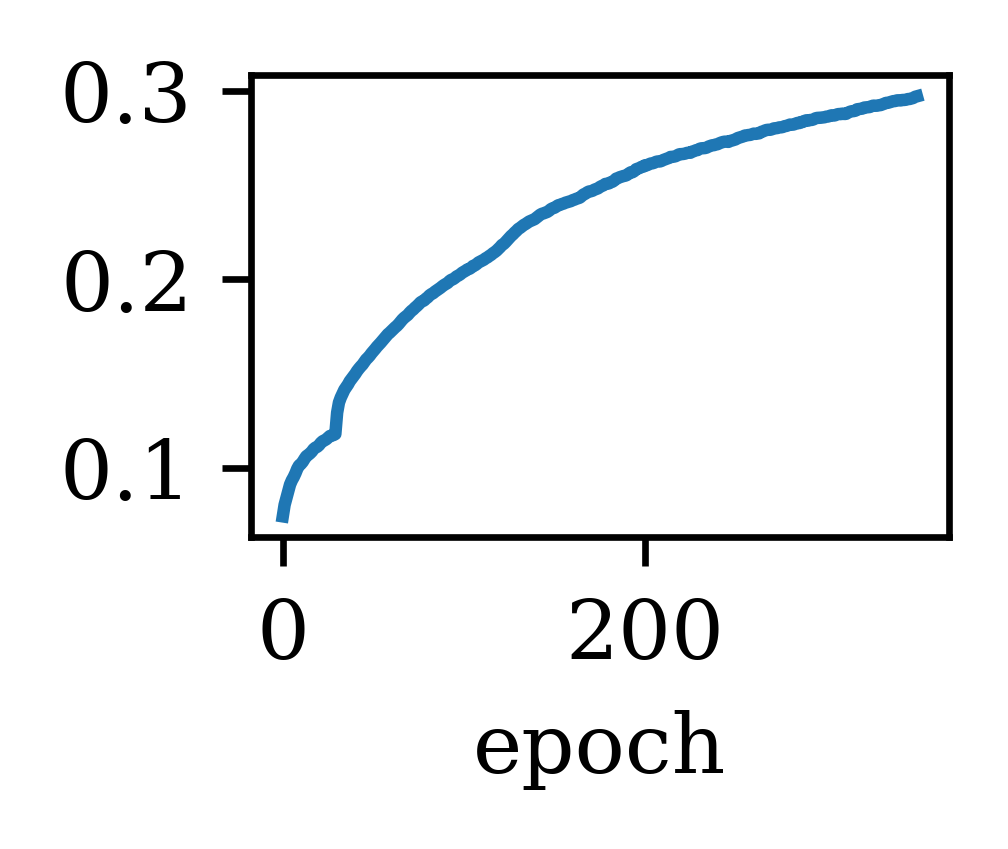

In [29]:
df.groupby('epoch')['90th_percentile_weight_sn'].mean().dropna().plot(figsize=(1.5, 1))

<Axes: xlabel='epoch'>

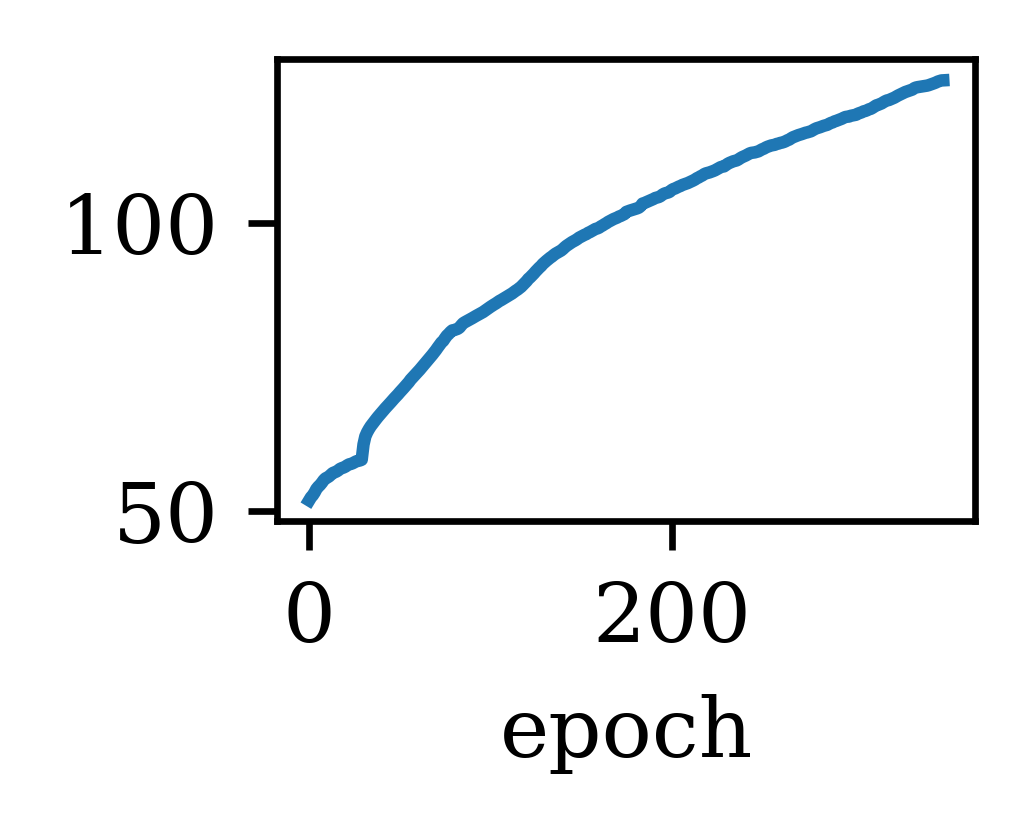

In [31]:
df.groupby('epoch')['sn_l2_loss'].mean().dropna().plot(figsize=(1.5, 1))

In [77]:
0.25 * 1e-4

2.5e-05

<Axes: xlabel='epoch'>

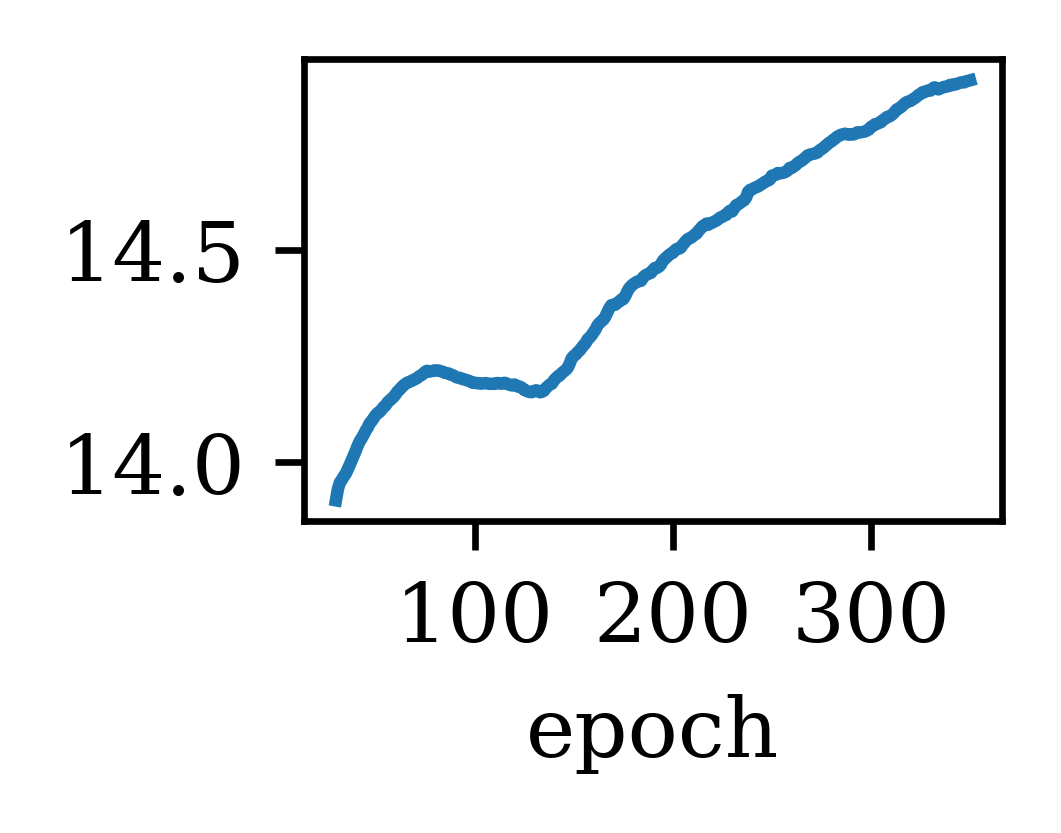

In [75]:
df.groupby('epoch')['class_l2_loss'].mean().dropna().plot(figsize=(1.5, 1))

In [52]:
import matplotlib.pyplot as plt

In [71]:
mag = []
for n in range(100, 100001, 1000):
    mag.append(np.mean(np.linalg.norm(np.random.randn(n, 200) / 4, 2, axis=0)) / np.sqrt(n))

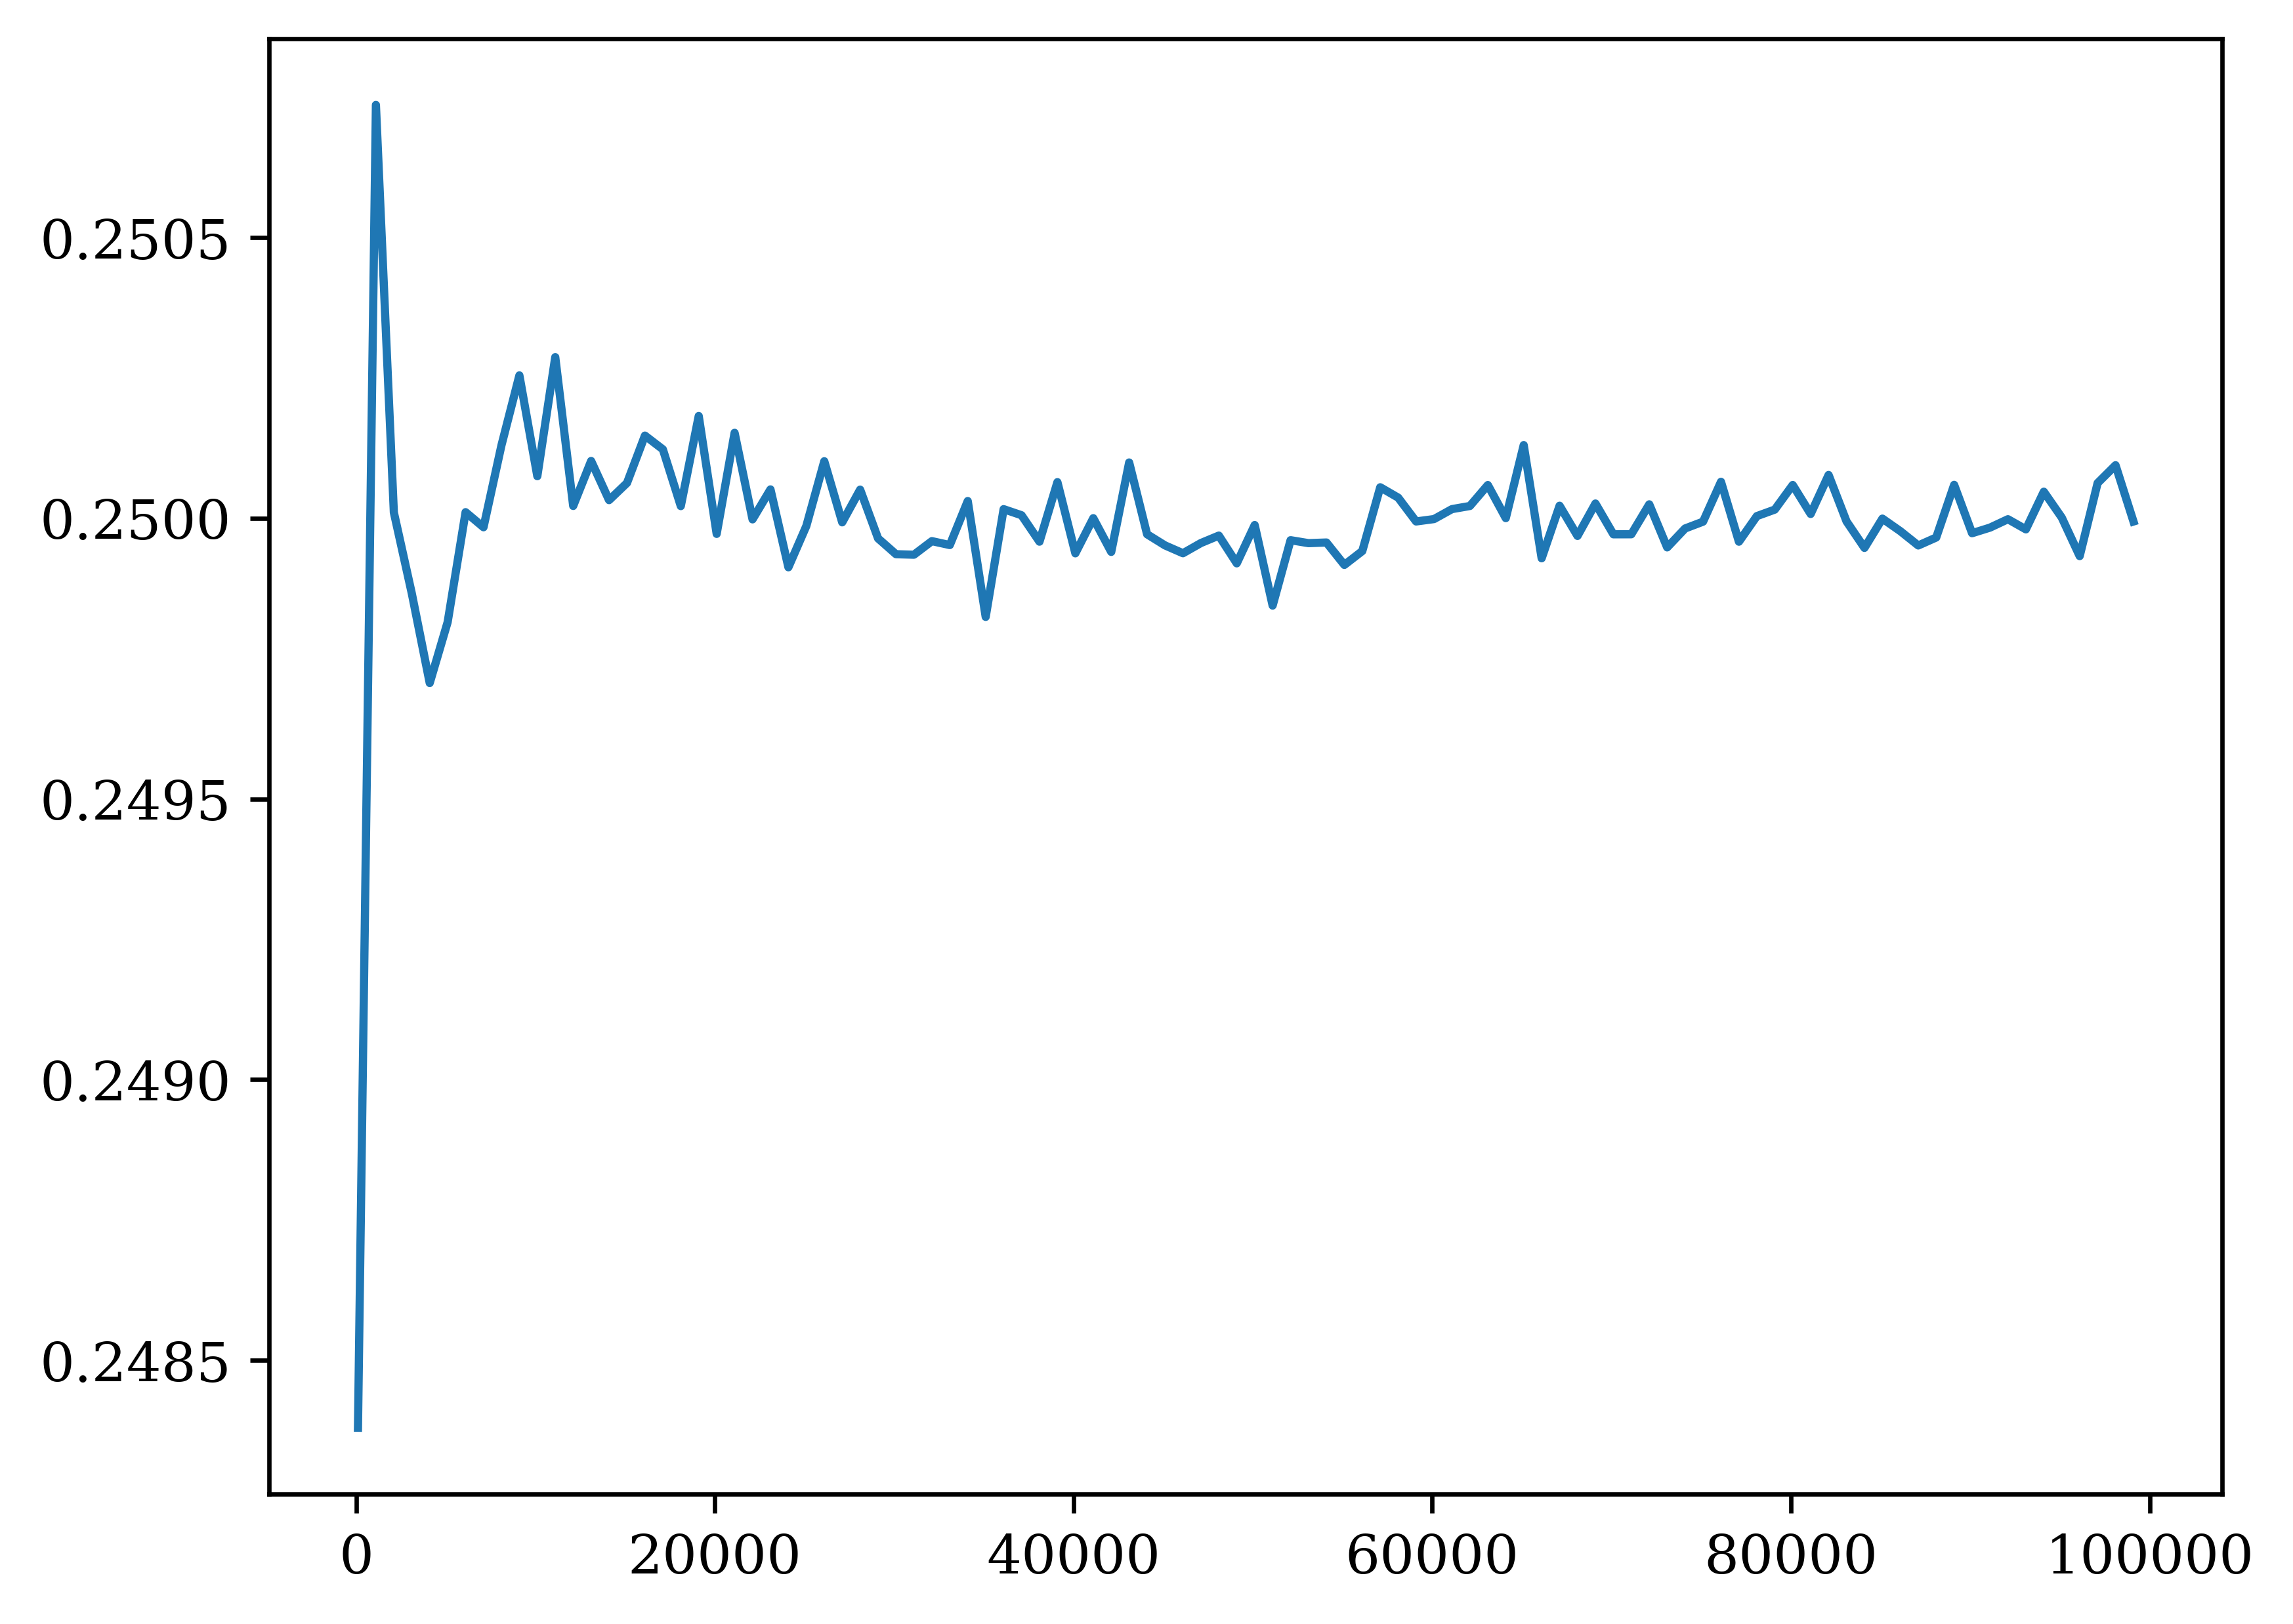

In [72]:
plt.plot(range(100, 100001, 1000), mag)